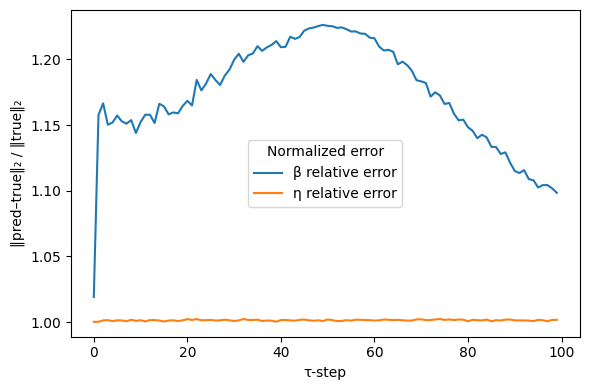

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Load your saved trajectories:
data       = np.load("configf_1200_0rots_very_big_b_eta/drift_noise_trajectories.npz")
b_hat_seq  = data["b_hat_seq"]    # e.g. shape (100, 1, D)
b_true_seq = data["b_true_seq"]
eta_hat_seq  = data["eta_hat_seq"]
eta_true_seq = data["eta_true_seq"]

# 2. Squeeze out that singleton middle dimension:
b_hat_seq   = b_hat_seq.squeeze(1)    # -> (100, D)
b_true_seq  = b_true_seq.squeeze(1)
eta_hat_seq = eta_hat_seq.squeeze(1)
eta_true_seq= eta_true_seq.squeeze(1)

# 3. Compute per‐step L2 errors and normalize by true‐vector norm:
eps = 1e-12
abs_err_b = np.linalg.norm(b_hat_seq - b_true_seq, axis=1)        # (100,)
rel_err_b = abs_err_b / (np.linalg.norm(b_true_seq, axis=1) + eps)

abs_err_eta = np.linalg.norm(eta_hat_seq - eta_true_seq, axis=1)
rel_err_eta = abs_err_eta / (np.linalg.norm(eta_true_seq, axis=1) + eps)

# 4. Plot
plt.figure(figsize=(6,4))
plt.plot(rel_err_b, label="β relative error")
plt.plot(rel_err_eta, label="η relative error")
plt.xlabel("τ‐step")
plt.ylabel("‖pred–true‖₂ / ‖true‖₂")
plt.legend(title="Normalized error")
plt.tight_layout()
plt.show()


shapes: (100, 120) (100, 120)


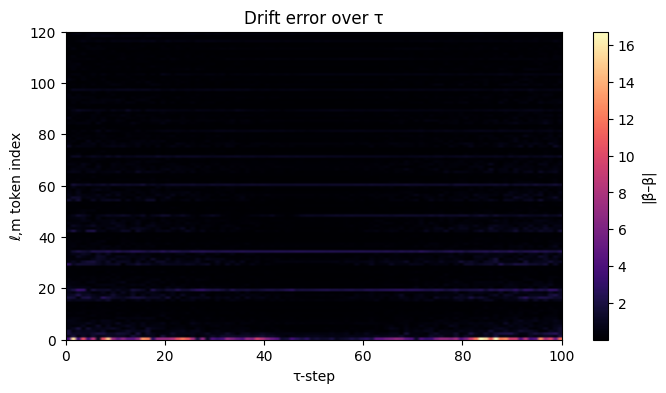

In [2]:
import pickle, torch, numpy as np, healpy as hp
from utils import real_to_complex_channel_stack
from loading_vanilla import unnorm_healpix_alms_final

# 1) reload your stats
all_stats = pickle.load(open("../sh_norm_stats_correct.pkl","rb"))

# 2) constants exactly as in your sampler
LMAX_RADIAL  = 14
N_PHASE_MAPS = 3
N_FG_CLASSES = 3

C_real_RADIAL = (LMAX_RADIAL+1)**2 + (LMAX_RADIAL+1)
C_real_FG     = (LMAX_RADIAL+1)**2 + (LMAX_RADIAL+1)  # unused here
C_real_BG     = (LMAX_RADIAL+1)**2 + (LMAX_RADIAL+1)  # unused here

# slice positions
sR, eR = 0, C_real_RADIAL
sF, eF = eR, eR + C_real_FG * N_PHASE_MAPS * N_FG_CLASSES
sB, eB = eF, eF + C_real_BG * N_PHASE_MAPS

def realvecs_to_alms(real_batch, lmax, stats_key):
    """
    real_batch: np.array (T, C_real)
    returns:    np.array (T, C_pos) of unnormalized Alm real‐parts
    """
    T, Creal = real_batch.shape
    Cpos = hp.Alm.getsize(lmax)

    # 1) reshape into (T, Cpos, 2)
    real3d = real_batch.reshape(T, Cpos, 2)

    # 2) stack into “complex” normalized form
    t = torch.from_numpy(real3d).float()            # (T, Cpos, 2)
    cplx_norm = real_to_complex_channel_stack(t)    # (T, Cpos, 2)

    # 3) unnormalize back to true Alm
    unnormed = unnorm_healpix_alms_final(cplx_norm, all_stats[stats_key])
    # unnormed is (T, Cpos, 2)  → take [:,:,0]
    return unnormed[:,:,0]

# 3) now load your drift trajectories and convert just the radial block
data        = np.load("configf_1200_0rots_very_big_b_eta/drift_noise_trajectories.npz")
b_hat_seq   = data["b_hat_seq"].squeeze(1)    # → (100, D)
b_true_seq  = data["b_true_seq"].squeeze(1)   # → (100, D)

rad_hat_alms  = realvecs_to_alms(b_hat_seq[:, sR:eR], LMAX_RADIAL, "radial")
rad_true_alms = realvecs_to_alms(b_true_seq[:,sR:eR], LMAX_RADIAL, "radial")

print("shapes:", rad_hat_alms.shape, rad_true_alms.shape)
# now rad_hat_alms and rad_true_alms are (100, C_pos_radial)

# 4) per‐token error heatmap
err = np.abs(rad_hat_alms - rad_true_alms)   # (100, Cpos)
plt.figure(figsize=(8,4))
plt.imshow(err.T, aspect="auto", origin="lower",
           extent=[0, err.shape[0], 0, err.shape[1]],
           cmap="magma")
plt.colorbar(label="|β̂–β|")
plt.xlabel("τ‐step")
plt.ylabel("ℓ,m token index")
plt.title("Drift error over τ")
plt.show()


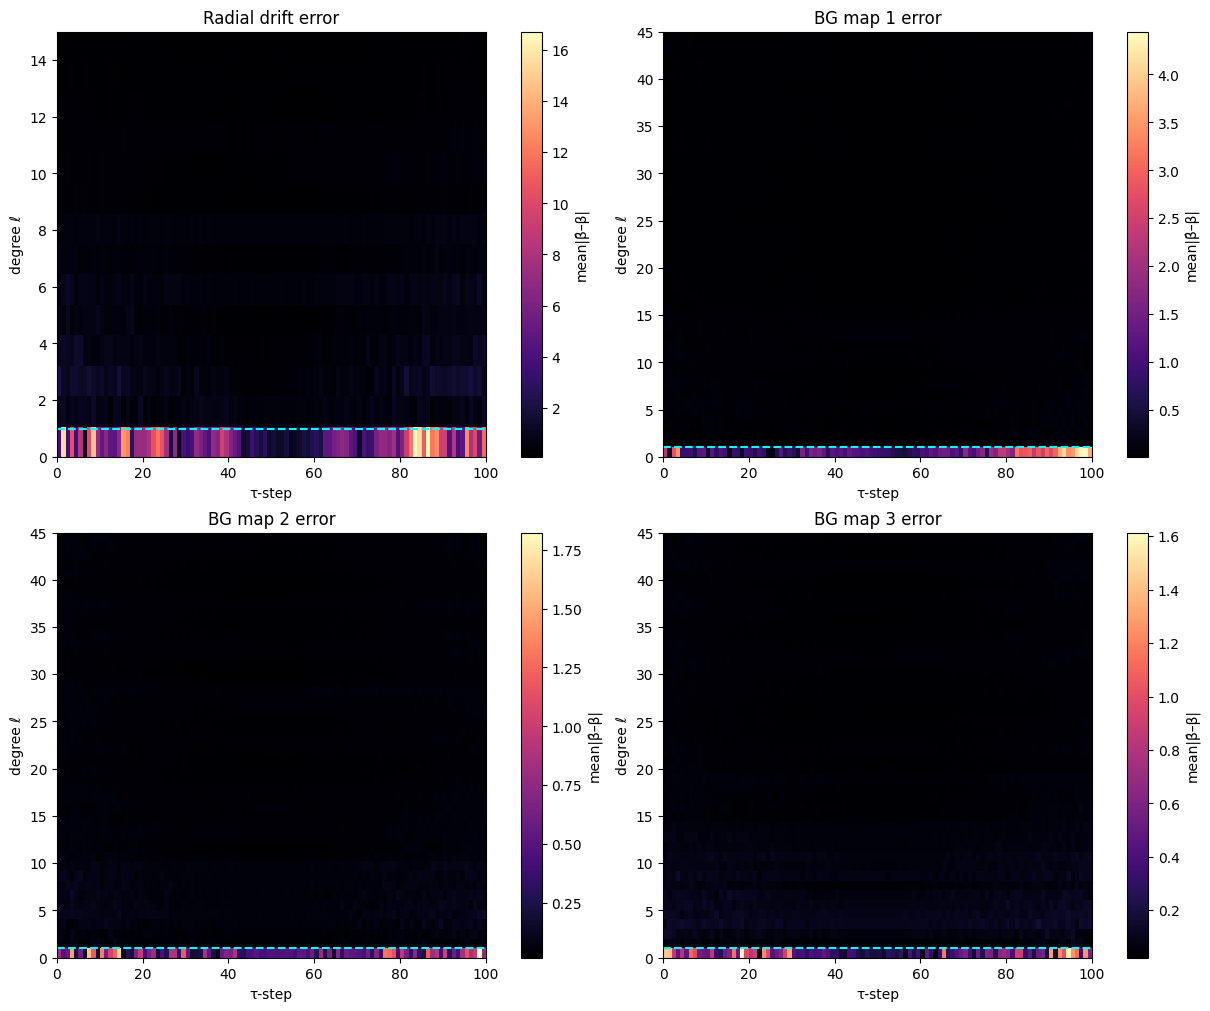

In [3]:
import pickle, torch, numpy as np, healpy as hp, matplotlib.pyplot as plt
from utils import real_to_complex_channel_stack
from loading_vanilla import unnorm_healpix_alms_final

# 1) reload your stats
all_stats = pickle.load(open("../sh_norm_stats_correct.pkl","rb"))

# 2) constants exactly as in your sampler
LMAX_RADIAL  = 14
LMAX_BG      = 44
N_PHASE_MAPS = 3

C_real_RADIAL = (LMAX_RADIAL+1)**2 + (LMAX_RADIAL+1)
C_real_BG     = (LMAX_BG    +1)**2 + (LMAX_BG    +1)

# slice positions (real-basis vector)
sR, eR = 0, C_real_RADIAL
sF, eF = eR, eR  # unused here
sB, eB = eF, eF + C_real_BG * N_PHASE_MAPS

def realvecs_to_alms(real_batch, lmax, stats_key):
    """
    real_batch: np.array (T, C_real)
    returns:    np.array (T, C_pos) of unnormalized Alm real‐parts
    """
    T, Creal = real_batch.shape
    Cpos = hp.Alm.getsize(lmax)

    # 1) reshape into (T, Cpos, 2)
    real3d = real_batch.reshape(T, Cpos, 2)

    # 2) stack into “complex” normalized form
    t = torch.from_numpy(real3d).float()            # (T, Cpos, 2)
    cplx_norm = real_to_complex_channel_stack(t)    # (T, Cpos, 2)

    # 3) unnormalize back to true Alm
    unnormed = unnorm_healpix_alms_final(cplx_norm, all_stats[stats_key])
    # unnormed is (T, Cpos, 2)  → take [:,:,0]
    return unnormed[:,:,0]

# 3) load your drift & noise trajectories
data        = np.load("configf_1200_0rots_very_big_b_eta/drift_noise_trajectories.npz")
b_hat_seq   = data["b_hat_seq"].squeeze(1)    # → (T, D)
b_true_seq  = data["b_true_seq"].squeeze(1)

# 4) extract radial & each BG block, convert to alms
rad_hat_alms  = realvecs_to_alms(b_hat_seq[:, sR:eR], LMAX_RADIAL, "radial")
rad_true_alms = realvecs_to_alms(b_true_seq[:,sR:eR], LMAX_RADIAL, "radial")
#print(rad_hat_alms.shape)

bg_hat_alms = []
bg_true_alms = []
for i in range(N_PHASE_MAPS):
    si = sB + i*C_real_BG
    ei = si + C_real_BG
    bg_hat_alms .append(realvecs_to_alms(b_hat_seq[:, si:ei], LMAX_BG, "phase_bg"))
    bg_true_alms.append(realvecs_to_alms(b_true_seq[:,si:ei], LMAX_BG, "phase_bg"))

T = rad_hat_alms.shape[0]

# 5) build ℓ→indices maps for radial & BG
l_rad, _ = hp.Alm.getlm(LMAX_RADIAL)
rad_inds = {ℓ: np.where(l_rad==ℓ)[0] for ℓ in range(LMAX_RADIAL)}

l_bg, _  = hp.Alm.getlm(LMAX_BG)
bg_inds  = {ℓ: np.where(l_bg==ℓ)[0] for ℓ in range(LMAX_BG)}

def mean_err_by_degree(hat, true, inds_dict):
    Lmax = max(inds_dict.keys())
    err = np.zeros((Lmax+1, T))
    for ℓ, idxs in inds_dict.items():
        d = np.abs(hat[:, idxs] - true[:, idxs]).mean(axis=1)
        err[ℓ] = d
    return err

err_rad = mean_err_by_degree(rad_hat_alms, rad_true_alms, rad_inds)
err_bg1 = mean_err_by_degree(bg_hat_alms[0], bg_true_alms[0], bg_inds)
err_bg2 = mean_err_by_degree(bg_hat_alms[1], bg_true_alms[1], bg_inds)
err_bg3 = mean_err_by_degree(bg_hat_alms[2], bg_true_alms[2], bg_inds)

# 6) plot 2×2
fig, axs = plt.subplots(2,2, figsize=(12,10), constrained_layout=True)
plots = [(err_rad, LMAX_RADIAL, "Radial drift error"),
         (err_bg1, LMAX_BG,   "BG map 1 error"),
         (err_bg2, LMAX_BG,   "BG map 2 error"),
         (err_bg3, LMAX_BG,   "BG map 3 error")]

for ax, (err_deg, Lmax, title) in zip(axs.flat, plots):
    im = ax.imshow(err_deg, origin='lower', aspect='auto',
                   extent=[0, T, 0, Lmax+1], cmap='magma')
    ax.set_title(title)
    ax.set_xlabel('τ-step')
    ax.set_ylabel('degree ℓ')
    ax.axhline(1, color='cyan', ls='--', lw=1.5)
    fig.colorbar(im, ax=ax, label='mean|β̂–β|')

plt.show()


In [6]:
import numpy as np

# 1. Load your saved trajectories:
data        = np.load("configf_1200_0rots_very_big_b_eta/drift_noise_trajectories.npz")
b_hat_seq  = data["b_hat_seq"]      # e.g. shape (100, 1, D)
b_true_seq = data["b_true_seq"]
eta_hat_seq  = data["eta_hat_seq"]
eta_true_seq = data["eta_true_seq"]

# 2. Squeeze out that singleton middle dimension:
b_hat_seq   = b_hat_seq.squeeze(1)     # -> (100, D)
b_true_seq  = b_true_seq.squeeze(1)
eta_hat_seq = eta_hat_seq.squeeze(1)
eta_true_seq= eta_true_seq.squeeze(1)

# 3. Print the shapes
print(f"Shape of b_hat_seq: {b_hat_seq.shape}")
print(f"Shape of b_true_seq: {b_true_seq.shape}")
print(f"Shape of eta_hat_seq: {eta_hat_seq.shape}")
print(f"Shape of eta_true_seq: {eta_true_seq.shape}")

Shape of b_hat_seq: (100, 11418)
Shape of b_true_seq: (100, 11418)
Shape of eta_hat_seq: (100, 11418)
Shape of eta_true_seq: (100, 11418)


Calculated total D based on LMAX values: 11418
Shape of b_hat_seq after squeeze: (100, 11418)


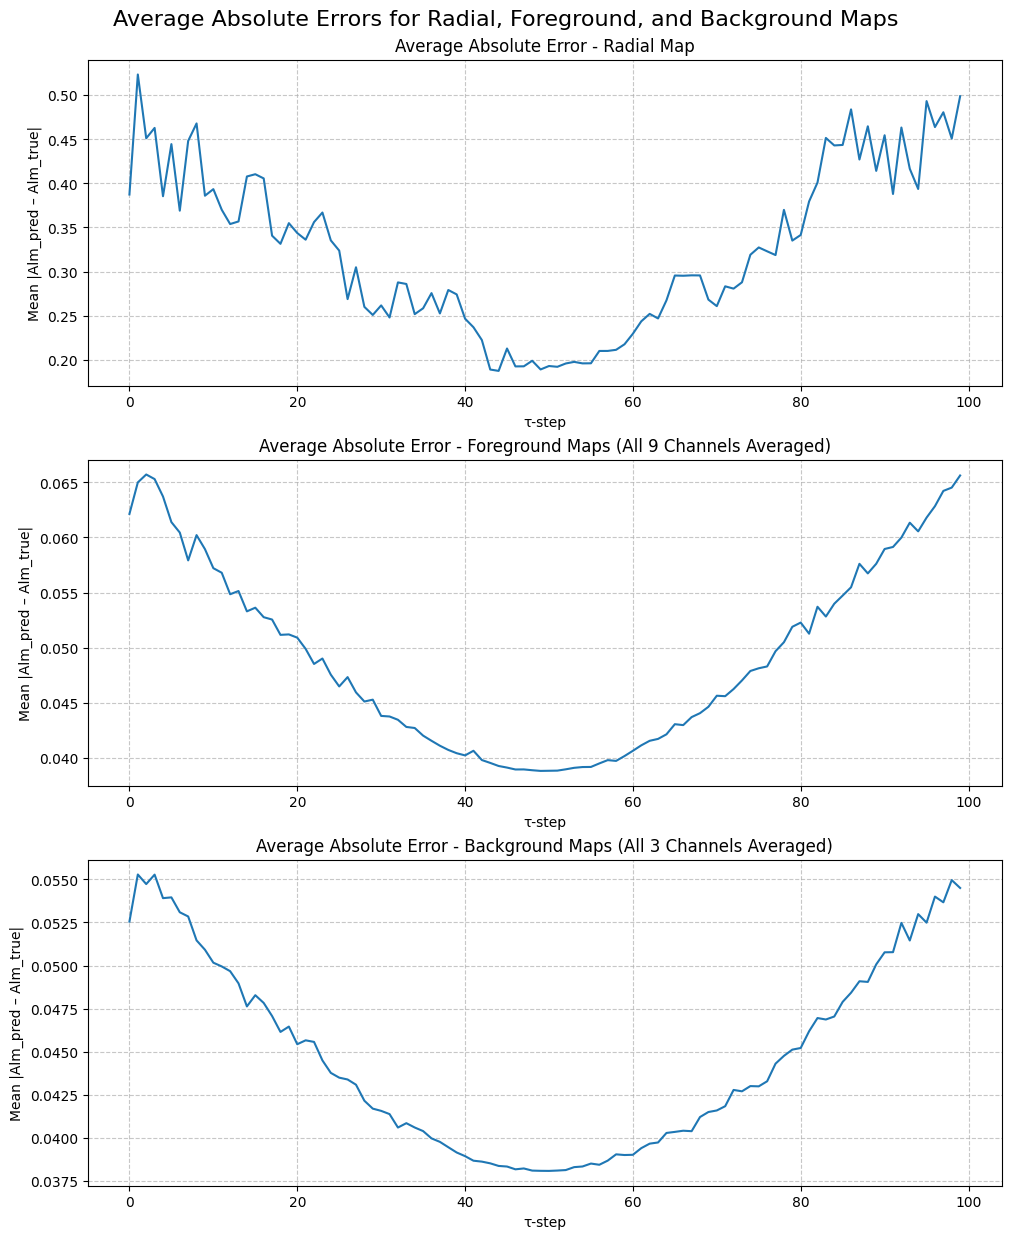

In [7]:
import pickle, torch, numpy as np, healpy as hp, matplotlib.pyplot as plt
# Assuming utils and loading_vanilla are correctly imported/accessible
from utils import real_to_complex_channel_stack
from loading_vanilla import unnorm_healpix_alms_final

# 1) reload your stats
all_stats = pickle.load(open("../sh_norm_stats_correct.pkl","rb"))

# 2) constants based on confirmed LMAX values and structure
LMAX_RADIAL  = 14
LMAX_FG      = 22 # Confirmed LMAX for Foreground maps
LMAX_BG      = 44
N_PHASE_MAPS = 3
N_FG_CLASSES = 3

# C_real for a single complex map of each type (Alm.getsize(LMAX)*2)
C_real_RADIAL = (LMAX_RADIAL+1)**2 + (LMAX_RADIAL+1)
C_real_FG     = (LMAX_FG    +1)**2 + (LMAX_FG    +1)
C_real_BG     = (LMAX_BG    +1)**2 + (LMAX_BG    +1)

# Calculate correct slice positions for the entire D vector (11418)
sR, eR = 0, C_real_RADIAL
sF, eF = eR, eR + (C_real_FG * N_PHASE_MAPS * N_FG_CLASSES) # 9 FG complex channels in total
sB, eB = eF, eF + (C_real_BG * N_PHASE_MAPS)               # 3 BG complex channels in total

# Verify total D matches
expected_D = (eR - sR) + (eF - sF) + (eB - sB)
print(f"Calculated total D based on LMAX values: {expected_D}") # Should be 11418

def realvecs_to_alms(real_batch, lmax, stats_key):
    """
    real_batch: np.array (T, C_real) - C_real is the real-vector size for ONE map
    returns:    np.array (T, C_pos) of unnormalized Alm real‐parts
    """
    T, Creal = real_batch.shape
    Cpos = hp.Alm.getsize(lmax)

    # Reshape (T, Creal) into (T, Cpos, 2) for complex stacking
    real3d = real_batch.reshape(T, Cpos, 2)

    # Stack into “complex” normalized form (from real/imag parts in Cpos,2)
    t = torch.from_numpy(real3d).float()           # (T, Cpos, 2)
    cplx_norm = real_to_complex_channel_stack(t)    # (T, Cpos, 2)

    # Unnormalize back to true Alm
    unnormed = unnorm_healpix_alms_final(cplx_norm, all_stats[stats_key])
    # unnormed is (T, Cpos, 2)  → take [:,:,0] for the real-part of Alm
    return unnormed[:,:,0] # We are interested in the real part of the unnormalized Alms for comparison

# 3) load your drift & noise trajectories
data        = np.load("configf_1200_0rots_very_big_b_eta/drift_noise_trajectories.npz")
b_hat_seq   = data["b_hat_seq"].squeeze(1)    # -> (T, D)
b_true_seq  = data["b_true_seq"].squeeze(1)

T = b_hat_seq.shape[0] # Number of time steps

print(f"Shape of b_hat_seq after squeeze: {b_hat_seq.shape}") # (100, 11418)

# 4) Extract and convert radial block
rad_hat_alms  = realvecs_to_alms(b_hat_seq[:, sR:eR], LMAX_RADIAL, "radial")
rad_true_alms = realvecs_to_alms(b_true_seq[:,sR:eR], LMAX_RADIAL, "radial")

# 5) Extract and convert FG blocks (9 channels in total)
# Each FG channel has C_real_FG coefficients. There are N_PHASE_MAPS * N_FG_CLASSES such channels.
fg_hat_alms_list = []
fg_true_alms_list = []
for i in range(N_PHASE_MAPS * N_FG_CLASSES): # Loop 9 times (3*3)
    si_channel = sF + i * C_real_FG
    ei_channel = si_channel + C_real_FG
    fg_hat_alms_list.append(realvecs_to_alms(b_hat_seq[:, si_channel:ei_channel], LMAX_FG, "phase_fg"))
    fg_true_alms_list.append(realvecs_to_alms(b_true_seq[:, si_channel:ei_channel], LMAX_FG, "phase_fg"))

# 6) Extract and convert BG blocks (3 channels in total)
# Each BG channel has C_real_BG coefficients. There are N_PHASE_MAPS such channels.
bg_hat_alms_list = []
bg_true_alms_list = []
for i in range(N_PHASE_MAPS): # Loop 3 times
    si_channel = sB + i * C_real_BG
    ei_channel = si_channel + C_real_BG
    bg_hat_alms_list.append(realvecs_to_alms(b_hat_seq[:, si_channel:ei_channel], LMAX_BG, "phase_bg"))
    bg_true_alms_list.append(realvecs_to_alms(b_true_seq[:, si_channel:ei_channel], LMAX_BG, "phase_bg"))

# 7) Compute absolute errors for each map type (per-Alm token)
err_rad_per_token = np.abs(rad_hat_alms - rad_true_alms) # (T, Cpos_radial)

# For FG and BG, compute error for each channel, then stack
err_fg_channels_list = [np.abs(h - t) for h, t in zip(fg_hat_alms_list, fg_true_alms_list)] # List of (T, Cpos_fg)
err_bg_channels_list = [np.abs(h - t) for h, t in zip(bg_hat_alms_list, bg_true_alms_list)] # List of (T, Cpos_bg)

# 8) Average errors across tokens (for each map) and then across channels
# For radial: average over Cpos dimension for each time step
mean_abs_err_rad = np.mean(err_rad_per_token, axis=1) # (T,)

# For FG: Stack all channel errors, then average over channel dimension (axis=0), then over Cpos (axis=1)
# Resulting shape after stack: (N_FG_channels, T, Cpos_fg)
stacked_fg_errors = np.stack(err_fg_channels_list, axis=0)
mean_abs_err_fg = np.mean(np.mean(stacked_fg_errors, axis=0), axis=1) # (T,)

# For BG: Stack all channel errors, then average over channel dimension (axis=0), then over Cpos (axis=1)
# Resulting shape after stack: (N_BG_channels, T, Cpos_bg)
stacked_bg_errors = np.stack(err_bg_channels_list, axis=0)
mean_abs_err_bg = np.mean(np.mean(stacked_bg_errors, axis=0), axis=1) # (T,)

# 9) Plotting the 3x1 figure
fig, axs = plt.subplots(3, 1, figsize=(10, 12), constrained_layout=True)

# Plot Radial Error
axs[0].plot(mean_abs_err_rad)
axs[0].set_title("Average Absolute Error - Radial Map")
axs[0].set_xlabel("τ-step")
axs[0].set_ylabel("Mean |Alm_pred – Alm_true|")
axs[0].grid(True, linestyle='--', alpha=0.7)

# Plot FG Error
axs[1].plot(mean_abs_err_fg)
axs[1].set_title("Average Absolute Error - Foreground Maps (All 9 Channels Averaged)")
axs[1].set_xlabel("τ-step")
axs[1].set_ylabel("Mean |Alm_pred – Alm_true|")
axs[1].grid(True, linestyle='--', alpha=0.7)

# Plot BG Error
axs[2].plot(mean_abs_err_bg)
axs[2].set_title("Average Absolute Error - Background Maps (All 3 Channels Averaged)")
axs[2].set_xlabel("τ-step")
axs[2].set_ylabel("Mean |Alm_pred – Alm_true|")
axs[2].grid(True, linestyle='--', alpha=0.7)

plt.suptitle("Average Absolute Errors for Radial, Foreground, and Background Maps", fontsize=16, y=1.02)
plt.show()

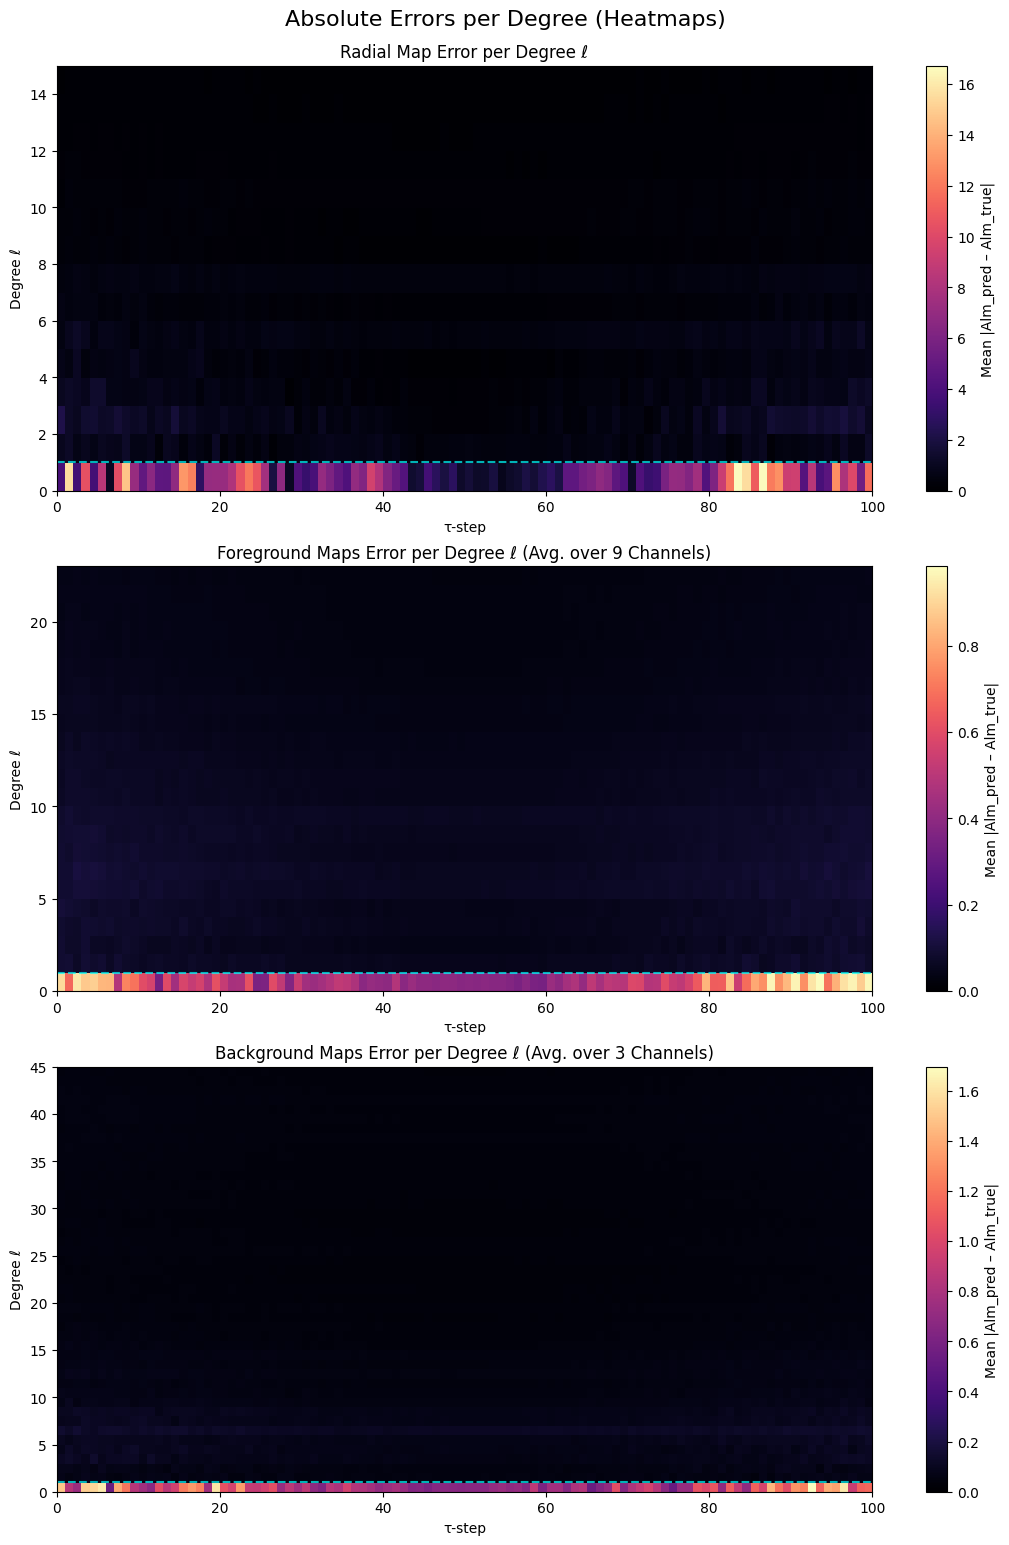

In [8]:
import pickle, torch, numpy as np, healpy as hp, matplotlib.pyplot as plt
from utils import real_to_complex_channel_stack
from loading_vanilla import unnorm_healpix_alms_final

# 1) reload your stats
all_stats = pickle.load(open("../sh_norm_stats_correct.pkl","rb"))

# 2) constants based on confirmed LMAX values and structure
LMAX_RADIAL  = 14
LMAX_FG      = 22 # Confirmed LMAX for Foreground maps
LMAX_BG      = 44
N_PHASE_MAPS = 3
N_FG_CLASSES = 3

# C_real for a single complex map of each type (Alm.getsize(LMAX)*2)
C_real_RADIAL = (LMAX_RADIAL+1)**2 + (LMAX_RADIAL+1)
C_real_FG     = (LMAX_FG    +1)**2 + (LMAX_FG    +1)
C_real_BG     = (LMAX_BG    +1)**2 + (LMAX_BG    +1)

# Calculate correct slice positions for the entire D vector
sR, eR = 0, C_real_RADIAL
sF, eF = eR, eR + (C_real_FG * N_PHASE_MAPS * N_FG_CLASSES) # 9 FG complex channels in total
sB, eB = eF, eF + (C_real_BG * N_PHASE_MAPS)               # 3 BG complex channels in total

def realvecs_to_alms(real_batch, lmax, stats_key):
    """
    real_batch: np.array (T, C_real) - C_real is the real-vector size for ONE map
    returns:    np.array (T, C_pos) of unnormalized Alm real‐parts
    """
    T, Creal = real_batch.shape
    Cpos = hp.Alm.getsize(lmax)

    # Reshape (T, Creal) into (T, Cpos, 2) for complex stacking
    real3d = real_batch.reshape(T, Cpos, 2)

    # Stack into “complex” normalized form (from real/imag parts in Cpos,2)
    t = torch.from_numpy(real3d).float()           # (T, Cpos, 2)
    cplx_norm = real_to_complex_channel_stack(t)    # (T, Cpos, 2)

    # Unnormalize back to true Alm
    unnormed = unnorm_healpix_alms_final(cplx_norm, all_stats[stats_key])
    # unnormed is (T, Cpos, 2)  → take [:,:,0] for the real-part of Alm
    return unnormed[:,:,0] # We are interested in the real part of the unnormalized Alms for comparison

# 3) load your drift & noise trajectories
data        = np.load("configf_1200_0rots_very_big_b_eta/drift_noise_trajectories.npz")
b_hat_seq   = data["b_hat_seq"].squeeze(1)    # -> (T, D)
b_true_seq  = data["b_true_seq"].squeeze(1)

T = b_hat_seq.shape[0] # Number of time steps

# 4) Extract and convert radial block
rad_hat_alms  = realvecs_to_alms(b_hat_seq[:, sR:eR], LMAX_RADIAL, "radial")
rad_true_alms = realvecs_to_alms(b_true_seq[:,sR:eR], LMAX_RADIAL, "radial")

# 5) Extract and convert FG blocks (9 channels in total)
fg_hat_alms_list = []
fg_true_alms_list = []
for i in range(N_PHASE_MAPS * N_FG_CLASSES): # Loop 9 times (3*3)
    si_channel = sF + i * C_real_FG
    ei_channel = si_channel + C_real_FG
    fg_hat_alms_list.append(realvecs_to_alms(b_hat_seq[:, si_channel:ei_channel], LMAX_FG, "phase_fg"))
    fg_true_alms_list.append(realvecs_to_alms(b_true_seq[:, si_channel:ei_channel], LMAX_FG, "phase_fg"))

# 6) Extract and convert BG blocks (3 channels in total)
bg_hat_alms_list = []
bg_true_alms_list = []
for i in range(N_PHASE_MAPS): # Loop 3 times
    si_channel = sB + i * C_real_BG
    ei_channel = si_channel + C_real_BG
    bg_hat_alms_list.append(realvecs_to_alms(b_hat_seq[:, si_channel:ei_channel], LMAX_BG, "phase_bg"))
    bg_true_alms_list.append(realvecs_to_alms(b_true_seq[:, si_channel:ei_channel], LMAX_BG, "phase_bg"))

# 7) Build ℓ→indices maps for radial, FG, and BG
l_rad, _ = hp.Alm.getlm(LMAX_RADIAL)
rad_inds = {ℓ: np.where(l_rad==ℓ)[0] for ℓ in range(LMAX_RADIAL + 1)} # +1 to include LMAX_RADIAL itself

l_fg, _  = hp.Alm.getlm(LMAX_FG)
fg_inds  = {ℓ: np.where(l_fg==ℓ)[0] for ℓ in range(LMAX_FG + 1)} # +1 to include LMAX_FG itself

l_bg, _  = hp.Alm.getlm(LMAX_BG)
bg_inds  = {ℓ: np.where(l_bg==ℓ)[0] for ℓ in range(LMAX_BG + 1)} # +1 to include LMAX_BG itself

def mean_err_by_degree(hat_alms_list, true_alms_list, inds_dict, Lmax):
    """
    Computes the mean absolute error per degree ℓ, averaged across channels (if multiple)
    and across m modes for that degree.
    hat_alms_list: List of (T, Cpos) arrays for predicted Alms (one entry per channel)
    true_alms_list: List of (T, Cpos) arrays for true Alms (one entry per channel)
    inds_dict: Dictionary mapping ℓ to Alm indices for that ℓ
    Lmax: The maximum ℓ degree for this map type
    returns: np.array (Lmax+1, T) with mean absolute error per degree per time step
    """
    err_per_degree_per_channel = []
    for hat, true in zip(hat_alms_list, true_alms_list):
        err_this_channel = np.zeros((Lmax + 1, hat.shape[0])) # (Lmax+1, T)
        for ℓ, idxs in inds_dict.items():
            if len(idxs) > 0: # Ensure there are modes for this degree
                err_this_channel[ℓ] = np.abs(hat[:, idxs] - true[:, idxs]).mean(axis=1)
            else:
                err_this_channel[ℓ] = np.nan # No modes for this degree
        err_per_degree_per_channel.append(err_this_channel)

    # Average across channels
    # Stack them: (N_channels, Lmax+1, T)
    stacked_err = np.stack(err_per_degree_per_channel, axis=0)
    # Mean across channels (axis=0), resulting in (Lmax+1, T)
    avg_err_across_channels = np.nanmean(stacked_err, axis=0) # Use nanmean to handle possible empty degrees
    return avg_err_across_channels

# Calculate errors per degree for each map type
# Radial maps: Only one "channel" for radial
err_rad_deg = mean_err_by_degree([rad_hat_alms], [rad_true_alms], rad_inds, LMAX_RADIAL)

# FG maps: 9 channels, average their errors per degree
err_fg_deg = mean_err_by_degree(fg_hat_alms_list, fg_true_alms_list, fg_inds, LMAX_FG)

# BG maps: 3 channels, average their errors per degree
err_bg_deg = mean_err_by_degree(bg_hat_alms_list, bg_true_alms_list, bg_inds, LMAX_BG)


# 8) Plotting the 3x1 heatmap figure
fig, axs = plt.subplots(3, 1, figsize=(10, 15), constrained_layout=True)

plots_data = [
    (err_rad_deg, LMAX_RADIAL, "Radial Map Error per Degree ℓ"),
    (err_fg_deg, LMAX_FG, "Foreground Maps Error per Degree ℓ (Avg. over 9 Channels)"),
    (err_bg_deg, LMAX_BG, "Background Maps Error per Degree ℓ (Avg. over 3 Channels)")
]

for ax, (err_deg_data, Lmax_val, title) in zip(axs.flat, plots_data):
    im = ax.imshow(err_deg_data, origin='lower', aspect='auto',
                   extent=[0, T, 0, Lmax_val + 1], cmap='magma', vmin=0) # vmin=0 ensures color scale starts at 0
    ax.set_title(title)
    ax.set_xlabel('τ-step')
    ax.set_ylabel('Degree ℓ')
    
    # Add a horizontal line at ℓ=1 for reference, similar to your original plot
    ax.axhline(1, color='cyan', ls='--', lw=1.5, alpha=0.7)
    
    fig.colorbar(im, ax=ax, label='Mean |Alm_pred – Alm_true|')

plt.suptitle("Absolute Errors per Degree (Heatmaps)", fontsize=16, y=1.02)
plt.show()

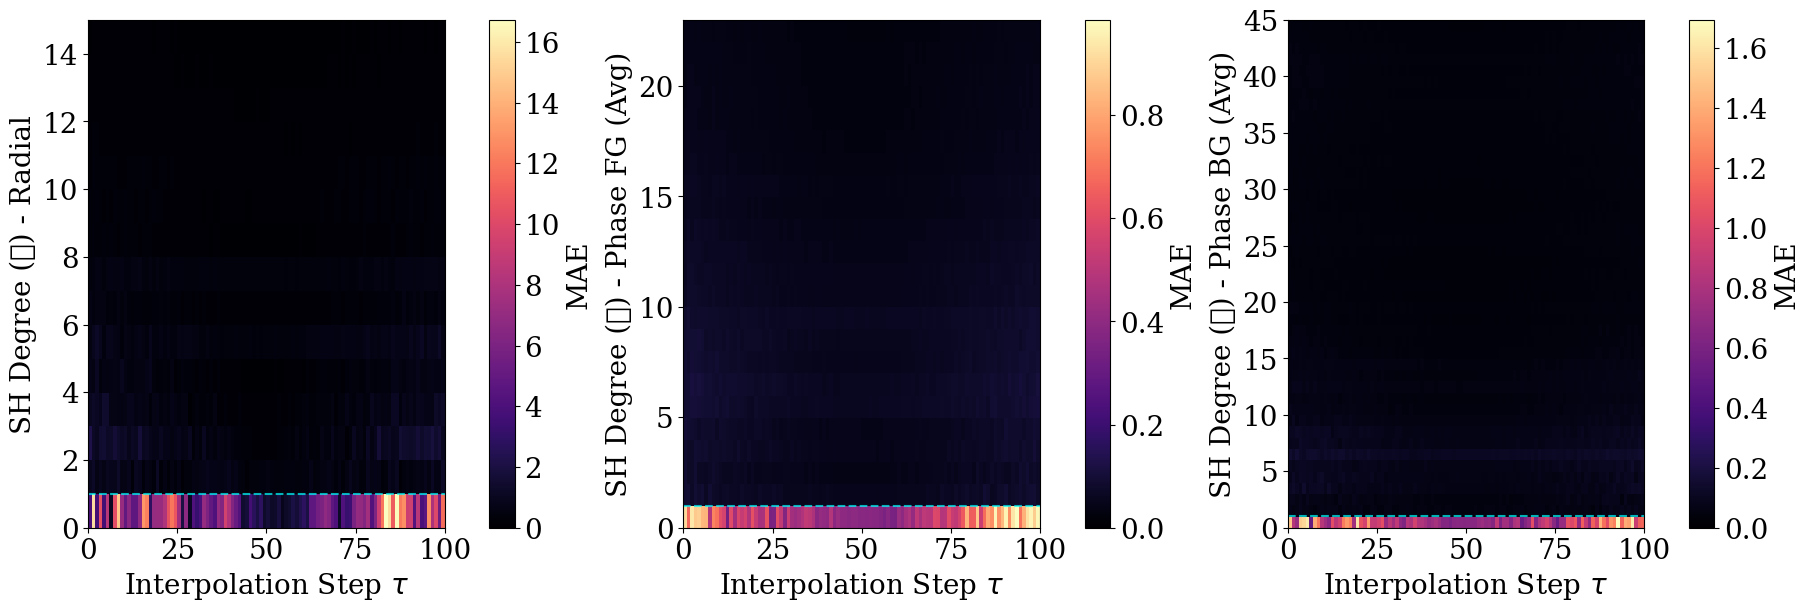

In [37]:
import pickle, torch, numpy as np, healpy as hp, matplotlib.pyplot as plt
from utils import real_to_complex_channel_stack
from loading_vanilla import unnorm_healpix_alms_final

# --- Configuration Constants (Confirmed from previous steps) ---
LMAX_RADIAL  = 14
LMAX_FG      = 22
LMAX_BG      = 44
N_PHASE_MAPS = 3
N_FG_CLASSES = 3

# C_real for a single complex map of each type (Alm.getsize(LMAX)*2)
C_real_RADIAL = (LMAX_RADIAL+1)**2 + (LMAX_RADIAL+1)
C_real_FG     = (LMAX_FG    +1)**2 + (LMAX_FG    +1)
C_real_BG     = (LMAX_BG    +1)**2 + (LMAX_BG    +1)

# Calculate correct slice positions for the entire D vector
sR, eR = 0, C_real_RADIAL
sF, eF = eR, eR + (C_real_FG * N_PHASE_MAPS * N_FG_CLASSES) # 9 FG complex channels in total
sB, eB = eF, eF + (C_real_BG * N_PHASE_MAPS)               # 3 BG complex channels in total

# --- Helper Function to Convert Real Vectors to Alms ---
def realvecs_to_alms(real_batch, lmax, stats_key):
    """
    Converts a batch of real-valued vector representations of spherical harmonic
    coefficients back to unnormalized Alm real-parts.

    Args:
        real_batch (np.array): Input array of shape (T, C_real), where T is
                               the number of time steps and C_real is the
                               real-vector size for one map.
        lmax (int): The maximum spherical harmonic degree.
        stats_key (str): Key to access normalization statistics from all_stats.

    Returns:
        np.array: Array of shape (T, C_pos) representing the real-parts of
                  unnormalized spherical harmonic coefficients.
    """
    T, Creal = real_batch.shape
    Cpos = hp.Alm.getsize(lmax)

    # Reshape (T, Creal) into (T, Cpos, 2) for complex stacking (real, imag)
    real3d = real_batch.reshape(T, Cpos, 2)

    # Convert to PyTorch tensor and stack into complex normalized form
    t = torch.from_numpy(real3d).float()
    cplx_norm = real_to_complex_channel_stack(t)

    # Unnormalize back to true Alm coefficients
    unnormed = unnorm_healpix_alms_final(cplx_norm, all_stats[stats_key])
    return unnormed[:,:,0] # Return the real part of the unnormalized Alms

# --- Helper Function to Calculate Mean Error by Degree ---
def mean_err_by_degree(hat_alms_list, true_alms_list, inds_dict, Lmax):
    """
    Computes the mean absolute error per spherical harmonic degree (ell),
    averaged across channels (if multiple) and across m modes for that degree.

    Args:
        hat_alms_list (list): List of (T, C_pos) arrays for predicted Alms,
                              one entry per channel.
        true_alms_list (list): List of (T, C_pos) arrays for true Alms,
                               one entry per channel.
        inds_dict (dict): Dictionary mapping spherical harmonic degree (ell)
                          to Alm indices for that ell.
        Lmax (int): The maximum spherical harmonic degree for this map type.

    Returns:
        np.array: Array of shape (Lmax+1, T) with mean absolute error per
                  degree per time step, averaged over channels.
    """
    err_per_degree_per_channel = []
    for hat, true in zip(hat_alms_list, true_alms_list):
        err_this_channel = np.zeros((Lmax + 1, hat.shape[0])) # (Lmax+1, T)
        for ℓ, idxs in inds_dict.items():
            if len(idxs) > 0: # Ensure there are modes for this degree
                err_this_channel[ℓ] = np.abs(hat[:, idxs] - true[:, idxs]).mean(axis=1)
            else:
                err_this_channel[ℓ] = np.nan # Mark as NaN if no modes for this degree
        err_per_degree_per_channel.append(err_this_channel)

    # Stack them: (N_channels, Lmax+1, T)
    stacked_err = np.stack(err_per_degree_per_channel, axis=0)
    # Mean across channels (axis=0), resulting in (Lmax+1, T)
    avg_err_across_channels = np.nanmean(stacked_err, axis=0) # Use nanmean to handle possible empty degrees
    return avg_err_across_channels

# --- Main Script ---
if __name__ == "__main__":
    # Load your drift & noise trajectories
    data        = np.load("configf_1200_0rots_very_big_b_eta/drift_noise_trajectories.npz")
    b_hat_seq   = data["b_hat_seq"].squeeze(1)
    b_true_seq  = data["b_true_seq"].squeeze(1)

    T = b_hat_seq.shape[0] # Number of time steps

    # Extract and convert radial block
    rad_hat_alms  = realvecs_to_alms(b_hat_seq[:, sR:eR], LMAX_RADIAL, "radial")
    rad_true_alms = realvecs_to_alms(b_true_seq[:,sR:eR], LMAX_RADIAL, "radial")

    # Extract and convert FG blocks (9 channels in total)
    fg_hat_alms_list = []
    fg_true_alms_list = []
    for i in range(N_PHASE_MAPS * N_FG_CLASSES):
        si_channel = sF + i * C_real_FG
        ei_channel = si_channel + C_real_FG
        fg_hat_alms_list.append(realvecs_to_alms(b_hat_seq[:, si_channel:ei_channel], LMAX_FG, "phase_fg"))
        fg_true_alms_list.append(realvecs_to_alms(b_true_seq[:, si_channel:ei_channel], LMAX_FG, "phase_fg"))

    # Extract and convert BG blocks (3 channels in total)
    bg_hat_alms_list = []
    bg_true_alms_list = []
    for i in range(N_PHASE_MAPS):
        si_channel = sB + i * C_real_BG
        ei_channel = si_channel + C_real_BG
        bg_hat_alms_list.append(realvecs_to_alms(b_hat_seq[:, si_channel:ei_channel], LMAX_BG, "phase_bg"))
        bg_true_alms_list.append(realvecs_to_alms(b_true_seq[:, si_channel:ei_channel], LMAX_BG, "phase_bg"))

    # Build ell-to-indices maps for all LMAX values
    l_rad, _ = hp.Alm.getlm(LMAX_RADIAL)
    rad_inds = {ℓ: np.where(l_rad==ℓ)[0] for ℓ in range(LMAX_RADIAL + 1)}

    l_fg, _  = hp.Alm.getlm(LMAX_FG)
    fg_inds  = {ℓ: np.where(l_fg==ℓ)[0] for ℓ in range(LMAX_FG + 1)}

    l_bg, _  = hp.Alm.getlm(LMAX_BG)
    bg_inds  = {ℓ: np.where(l_bg==ℓ)[0] for ℓ in range(LMAX_BG + 1)}

    # Calculate errors per degree for each map type
    err_rad_deg = mean_err_by_degree([rad_hat_alms], [rad_true_alms], rad_inds, LMAX_RADIAL)
    err_fg_deg = mean_err_by_degree(fg_hat_alms_list, fg_true_alms_list, fg_inds, LMAX_FG)
    err_bg_deg = mean_err_by_degree(bg_hat_alms_list, bg_true_alms_list, bg_inds, LMAX_BG)


    # --- Plotting the 1x3 heatmap figure for Publication Quality ---
    # Adjust figsize for a wider layout
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    plots_data = [
        (axs[0], err_rad_deg, LMAX_RADIAL, "Radial"),
        (axs[1], err_fg_deg, LMAX_FG, "Phase FG (Avg)"),
        (axs[2], err_bg_deg, LMAX_BG, "Phase BG (Avg)")
    ]

    # Define font sizes for publication quality
    TITLE_FONTSIZE = 22
    LABEL_FONTSIZE = 20
    TICK_FONTSIZE = 20
    CBAR_LABEL_FONTSIZE = 20

    for ax, err_deg_data, Lmax_val, map_type_label in plots_data:
        im = ax.imshow(err_deg_data, origin='lower', aspect='auto',
                       extent=[0, T, 0, Lmax_val + 1], cmap='magma', vmin=0)

        # Set axis labels and font sizes
        ax.set_xlabel(r'Interpolation Step $\tau$', fontsize=LABEL_FONTSIZE)
        ax.set_ylabel(f'SH Degree (ℓ) - {map_type_label}', fontsize=LABEL_FONTSIZE)

        # Set tick font sizes
        ax.tick_params(axis='x', labelsize=TICK_FONTSIZE)
        ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)

        # Add horizontal line at ℓ=1 for reference
        ax.axhline(1, color='cyan', ls='--', lw=1.5, alpha=0.7)

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, label='MAE')
        cbar.ax.tick_params(labelsize=CBAR_LABEL_FONTSIZE)
        cbar.set_label('MAE', fontsize=CBAR_LABEL_FONTSIZE)

    #plt.savefig('interpolation_mae.png', dpi=300)
    #plt.suptitle("Average Absolute Errors per Degree for Different Map Types", fontsize=TITLE_FONTSIZE, y=1.05)
    plt.show()

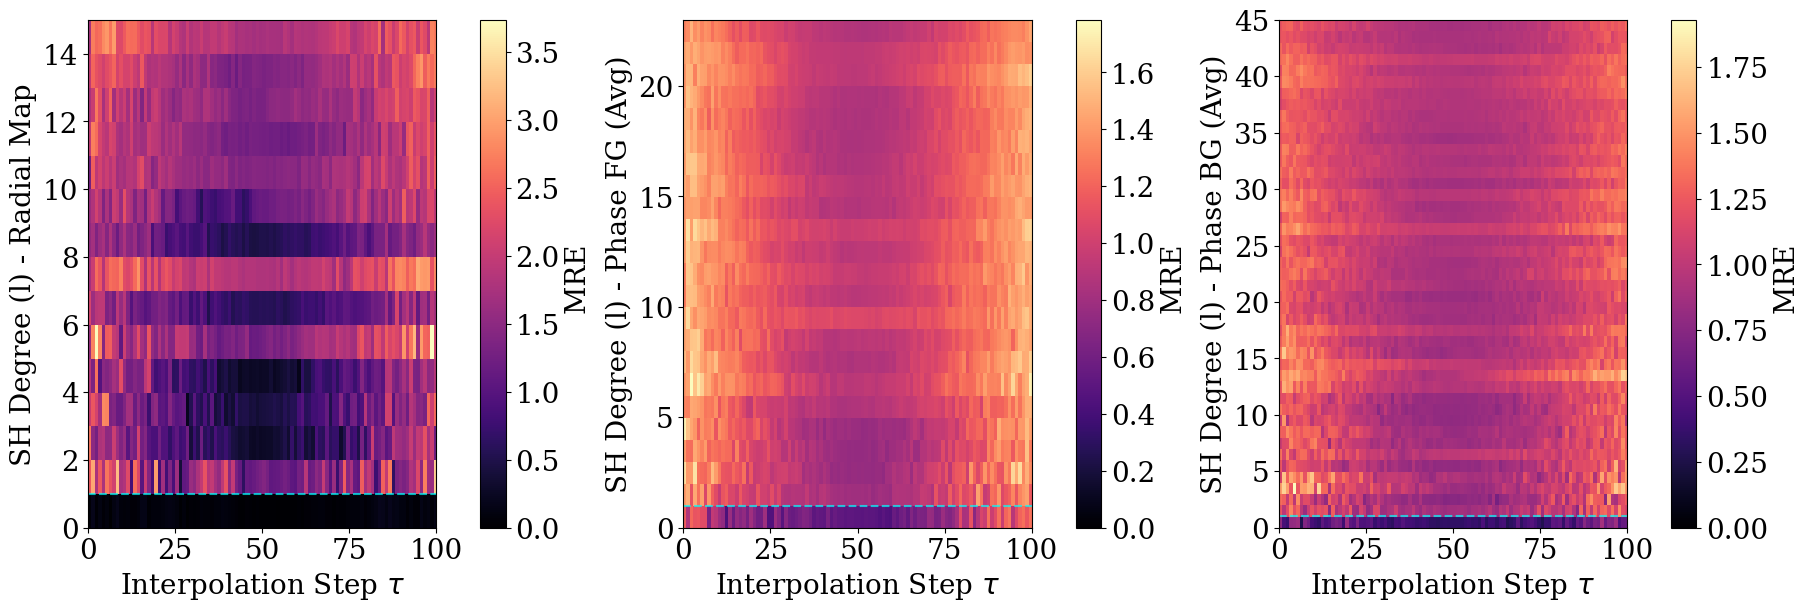

In [30]:
import pickle, torch, numpy as np, healpy as hp, matplotlib.pyplot as plt
from utils import real_to_complex_channel_stack
from loading_vanilla import unnorm_healpix_alms_final

# --- Matplotlib Font Setup (without LaTeX) ---
# Ensure text.usetex is explicitly set to False
plt.rcParams.update({
    "text.usetex": False, # This is the crucial line to disable LaTeX
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"], # A good default serif font for non-LaTeX
    "font.size": 12 # Default font size for general text, overridden by specific labels
})
# ---------------------------------------------

# --- Configuration Constants (Confirmed from previous steps) ---
LMAX_RADIAL  = 14
LMAX_FG      = 22 # Confirmed LMAX for Foreground maps
LMAX_BG      = 44
N_PHASE_MAPS = 3
N_FG_CLASSES = 3

# C_real for a single complex map of each type (Alm.getsize(LMAX)*2)
C_real_RADIAL = (LMAX_RADIAL+1)**2 + (LMAX_RADIAL+1)
C_real_FG     = (LMAX_FG    +1)**2 + (LMAX_FG    +1)
C_real_BG     = (LMAX_BG    +1)**2 + (LMAX_BG    +1)

# Calculate correct slice positions for the entire D vector
sR, eR = 0, C_real_RADIAL
sF, eF = eR, eR + (C_real_FG * N_PHASE_MAPS * N_FG_CLASSES) # 9 FG complex channels in total
sB, eB = eF, eF + (C_real_BG * N_PHASE_MAPS)               # 3 BG complex channels in total

# --- Helper Function to Convert Real Vectors to Alms ---
def realvecs_to_alms(real_batch, lmax, stats_key):
    """
    Converts a batch of real-valued vector representations of spherical harmonic
    coefficients back to unnormalized Alm real-parts.

    Args:
        real_batch (np.array): Input array of shape (T, C_real), where T is
                               the number of time steps and C_real is the
                               real-vector size for one map.
        lmax (int): The maximum spherical harmonic degree.
        stats_key (str): Key to access normalization statistics from all_stats.

    Returns:
        np.array: Array of shape (T, C_pos) representing the real-parts of
                  unnormalized spherical harmonic coefficients.
    """
    T, Creal = real_batch.shape
    Cpos = hp.Alm.getsize(lmax)

    # Reshape (T, Creal) into (T, Cpos, 2) for complex stacking (real, imag)
    real3d = real_batch.reshape(T, Cpos, 2)

    # Convert to PyTorch tensor and stack into complex normalized form
    t = torch.from_numpy(real3d).float()
    cplx_norm = real_to_complex_channel_stack(t)

    # Unnormalize back to true Alm coefficients
    unnormed = unnorm_healpix_alms_final(cplx_norm, all_stats[stats_key])
    return unnormed[:,:,0] # Return the real part of the unnormalized Alms

# --- Helper Function to Calculate Mean Relative Error by Degree ---
def rel_err_by_degree(hat_alms_list, true_alms_list, inds_dict, true_mean_per_ell, Lmax, epsilon=1e-12):
    """
    Computes the mean relative error per spherical harmonic degree (ell),
    averaged across channels (if multiple) and across m modes for that degree.

    Args:
        hat_alms_list (list): List of (T, C_pos) arrays for predicted Alms,
                              one entry per channel.
        true_alms_list (list): List of (T, C_pos) arrays for true Alms,
                               one entry per channel.
        inds_dict (dict): Dictionary mapping spherical harmonic degree (ell)
                          to Alm indices for that ell.
        true_mean_per_ell (dict): Dictionary mapping ell to the *global* average
                                  absolute true magnitude for that ell and map type.
        Lmax (int): The maximum spherical harmonic degree for this map type.
        epsilon (float): Small value to prevent division by zero.

    Returns:
        np.array: Array of shape (Lmax+1, T) with mean relative error per
                  degree per time step, averaged over channels.
    """
    rel_err_per_degree_per_channel = []
    for hat, true in zip(hat_alms_list, true_alms_list):
        rel_err_this_channel = np.zeros((Lmax + 1, hat.shape[0])) # (Lmax+1, T)
        for ell, idxs in inds_dict.items():
            if len(idxs) > 0: # Ensure there are modes for this degree
                # Absolute difference for current ell, averaged over m modes for each time step
                abs_diff_per_timestep = np.abs(hat[:, idxs] - true[:, idxs]).mean(axis=1) # (T,)

                # Get the mean true magnitude for this ell for the entire map type
                mean_true_mag_for_ell = true_mean_per_ell.get(ell, 0.0)

                # Calculate relative error: |diff| / (|true_mean_for_ell| + epsilon)
                rel_err_this_channel[ell] = np.divide(abs_diff_per_timestep,
                                                    (mean_true_mag_for_ell + epsilon),
                                                    out=np.full_like(abs_diff_per_timestep, np.nan), # Output NaN where denominator is too small
                                                    where=(mean_true_mag_for_ell + epsilon) > epsilon # Only divide if denominator is significant
                                                   )
            else:
                rel_err_this_channel[ell] = np.nan # Mark as NaN if no modes for this degree
        rel_err_per_degree_per_channel.append(rel_err_this_channel)

    # Stack them: (N_channels, Lmax+1, T)
    stacked_rel_err = np.stack(rel_err_per_degree_per_channel, axis=0)
    # Mean across channels (axis=0), resulting in (Lmax+1, T)
    avg_rel_err_across_channels = np.nanmean(stacked_rel_err, axis=0) # Use nanmean to handle NaNs from empty degrees or zero division
    return avg_rel_err_across_channels


# --- Main Script ---
if __name__ == "__main__":
    # Load your drift & noise trajectories
    data        = np.load("configf_1200_0rots_very_big_b_eta/drift_noise_trajectories.npz")
    b_hat_seq   = data["b_hat_seq"].squeeze(1)
    b_true_seq  = data["b_true_seq"].squeeze(1)

    T = b_hat_seq.shape[0] # Number of time steps

    # Extract and convert radial block
    rad_hat_alms  = realvecs_to_alms(b_hat_seq[:, sR:eR], LMAX_RADIAL, "radial")
    rad_true_alms = realvecs_to_alms(b_true_seq[:,sR:eR], LMAX_RADIAL, "radial")

    # Extract and convert FG blocks (9 channels in total)
    fg_hat_alms_list = []
    fg_true_alms_list = []
    for i in range(N_PHASE_MAPS * N_FG_CLASSES):
        si_channel = sF + i * C_real_FG
        ei_channel = si_channel + C_real_FG
        fg_hat_alms_list.append(realvecs_to_alms(b_hat_seq[:, si_channel:ei_channel], LMAX_FG, "phase_fg"))
        fg_true_alms_list.append(realvecs_to_alms(b_true_seq[:, si_channel:ei_channel], LMAX_FG, "phase_fg"))

    # Extract and convert BG blocks (3 channels in total)
    bg_hat_alms_list = []
    bg_true_alms_list = []
    for i in range(N_PHASE_MAPS):
        si_channel = sB + i * C_real_BG
        ei_channel = si_channel + C_real_BG
        bg_hat_alms_list.append(realvecs_to_alms(b_hat_seq[:, si_channel:ei_channel], LMAX_BG, "phase_bg"))
        bg_true_alms_list.append(realvecs_to_alms(b_true_seq[:, si_channel:ei_channel], LMAX_BG, "phase_bg"))

    # Build ell-to-indices maps for all LMAX values
    l_rad, _ = hp.Alm.getlm(LMAX_RADIAL)
    rad_inds = {ell: np.where(l_rad==ell)[0] for ell in range(LMAX_RADIAL + 1)}

    l_fg, _  = hp.Alm.getlm(LMAX_FG)
    fg_inds  = {ell: np.where(l_fg==ell)[0] for ell in range(LMAX_FG + 1)}

    l_bg, _  = hp.Alm.getlm(LMAX_BG)
    bg_inds  = {ell: np.where(l_bg==ell)[0] for ell in range(LMAX_BG + 1)}

    # --- Calculate Per-ell Average True Magnitude for Normalization ---
    # These are global averages per ell degree for the entire map type, across all channels.
    true_rad_mean = {ell: np.abs(rad_true_alms[:, idxs]).mean()
                     for ell, idxs in rad_inds.items() if len(idxs) > 0}

    true_fg_mean = {}
    for ell, idxs in fg_inds.items():
        if len(idxs) > 0:
            combined_true_fg_abs = np.concatenate([np.abs(fg_true_alms_list[j][:, idxs])
                                                   for j in range(N_PHASE_MAPS * N_FG_CLASSES)], axis=0)
            true_fg_mean[ell] = combined_true_fg_abs.mean()
        else:
            true_fg_mean[ell] = 0.0

    true_bg_mean = {}
    for ell, idxs in bg_inds.items():
        if len(idxs) > 0:
            combined_true_bg_abs = np.concatenate([np.abs(bg_true_alms_list[j][:, idxs])
                                                   for j in range(N_PHASE_MAPS)], axis=0)
            true_bg_mean[ell] = combined_true_bg_abs.mean()
        else:
            true_bg_mean[ell] = 0.0


    # Calculate relative errors per degree for each map type
    err_rad_deg_rel = rel_err_by_degree([rad_hat_alms], [rad_true_alms], rad_inds, true_rad_mean, LMAX_RADIAL)
    err_fg_deg_rel  = rel_err_by_degree(fg_hat_alms_list, fg_true_alms_list, fg_inds, true_fg_mean, LMAX_FG)
    err_bg_deg_rel  = rel_err_by_degree(bg_hat_alms_list, bg_true_alms_list, bg_inds, true_bg_mean, LMAX_BG)


    # --- Plotting the 1x3 heatmap figure for Publication Quality ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    plots_data = [
        (axs[0], err_rad_deg_rel, LMAX_RADIAL, "Radial Map"),
        (axs[1], err_fg_deg_rel, LMAX_FG, "Phase FG (Avg)"),
        (axs[2], err_bg_deg_rel, LMAX_BG, "Phase BG (Avg)")
    ]

    # Define font sizes for publication quality
    TITLE_FONTSIZE = 22
    LABEL_FONTSIZE = 20
    TICK_FONTSIZE = 20
    CBAR_LABEL_FONTSIZE = 20

    for ax, err_deg_data, Lmax_val, map_type_label in plots_data:
        im = ax.imshow(err_deg_data, origin='lower', aspect='auto',
                       extent=[0, T, 0, Lmax_val + 1], cmap='magma', vmin=0)

        # Set axis labels and font sizes
        ax.set_xlabel(r'Interpolation Step $\tau$', fontsize=LABEL_FONTSIZE)
        ax.set_ylabel(f'SH Degree (l) - {map_type_label}',  fontsize=LABEL_FONTSIZE)

        # Set tick font sizes
        ax.tick_params(axis='x', labelsize=TICK_FONTSIZE)
        ax.tick_params(axis='y', labelsize=TICK_FONTSIZE)

        # Add horizontal line at ell=1 for reference
        ax.axhline(1, color='cyan', ls='--', lw=1.5, alpha=0.7)

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, label='MRE')
        cbar.ax.tick_params(labelsize=CBAR_LABEL_FONTSIZE)
        cbar.set_label('MRE ', fontsize=CBAR_LABEL_FONTSIZE)

    plt.savefig('interpolation_mre.png', dpi=300)
    #plt.suptitle("Average Relative Errors per Degree for Different Map Types", fontsize=TITLE_FONTSIZE, y=1.05)
    plt.show()

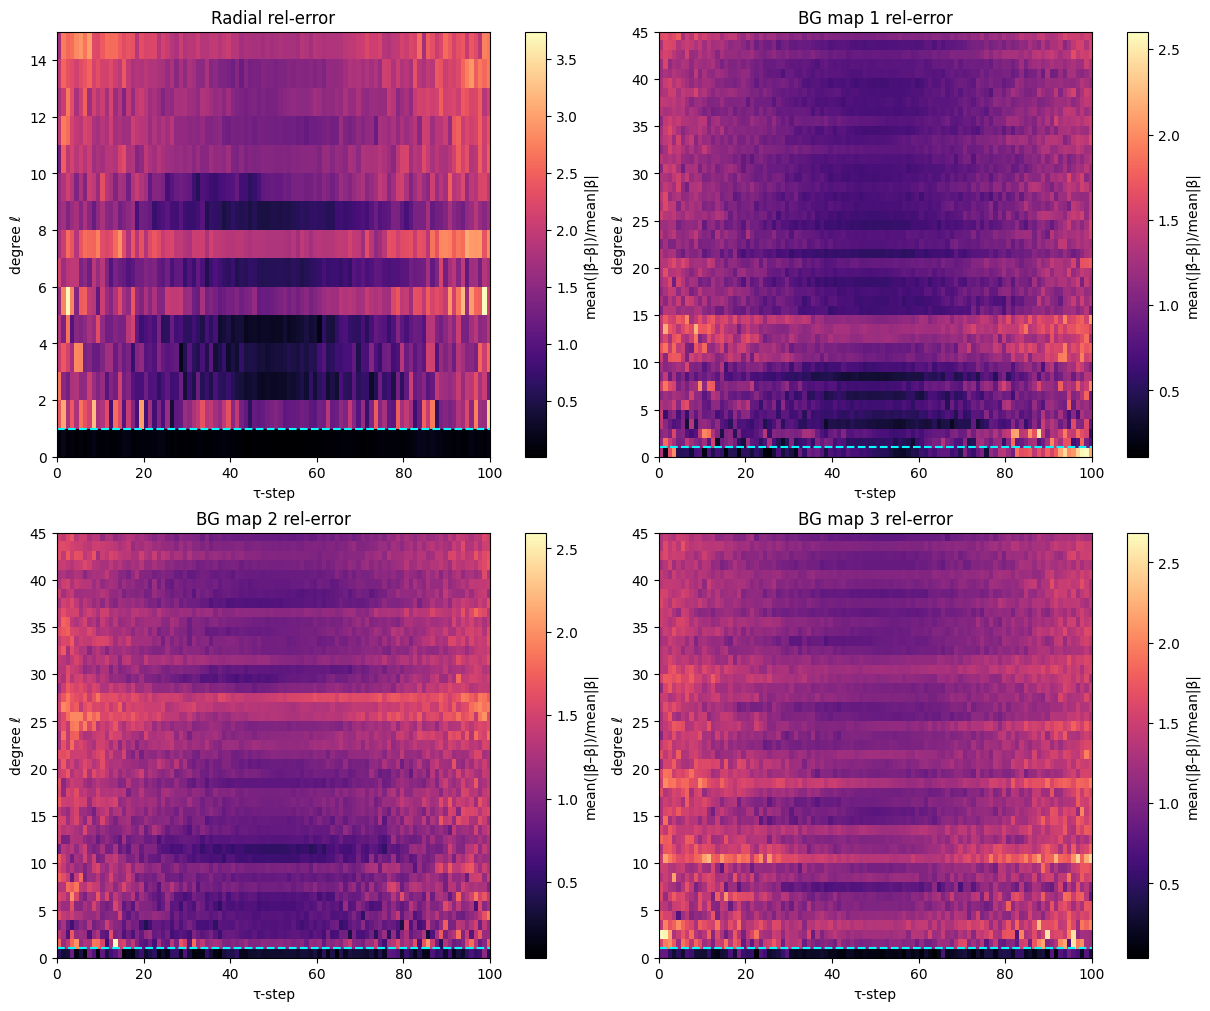

In [9]:
import pickle, torch, numpy as np, healpy as hp, matplotlib.pyplot as plt
from utils import real_to_complex_channel_stack
from loading_vanilla import unnorm_healpix_alms_final

# 1) reload your stats
all_stats = pickle.load(open("../sh_norm_stats_correct.pkl","rb"))

# 2) constants exactly as in your sampler
LMAX_RADIAL  = 14
LMAX_BG      = 44
N_PHASE_MAPS = 3

C_real_RADIAL = (LMAX_RADIAL+1)**2 + (LMAX_RADIAL+1)
C_real_BG     = (LMAX_BG    +1)**2 + (LMAX_BG    +1)

# slice positions (real-basis vector)
sR, eR = 0, C_real_RADIAL
sB, eB = eR, eR + C_real_BG * N_PHASE_MAPS

def realvecs_to_alms(real_batch, lmax, stats_key):
    T, Creal = real_batch.shape
    Cpos = hp.Alm.getsize(lmax)
    real3d = real_batch.reshape(T, Cpos, 2)
    t = torch.from_numpy(real3d).float()
    cplx_norm = real_to_complex_channel_stack(t)
    unnormed = unnorm_healpix_alms_final(cplx_norm, all_stats[stats_key])
    return unnormed[:,:,0]

# 3) load your drift trajectories
data       = np.load("configf_1200_0rots_very_big_b_eta/drift_noise_trajectories.npz")
b_hat_seq  = data["b_hat_seq"].squeeze(1)  # (T, D)
b_true_seq = data["b_true_seq"].squeeze(1)

# 4) convert blocks to Alm
rad_hat = realvecs_to_alms(b_hat_seq[:, sR:eR],    LMAX_RADIAL, "radial")
rad_true= realvecs_to_alms(b_true_seq[:,sR:eR],    LMAX_RADIAL, "radial")

bg_hat = []
bg_true= []
for i in range(N_PHASE_MAPS):
    si = sB + i*C_real_BG
    ei = si + C_real_BG
    bg_hat .append(realvecs_to_alms(b_hat_seq[:, si:ei], LMAX_BG, "phase_bg"))
    bg_true.append(realvecs_to_alms(b_true_seq[:,si:ei], LMAX_BG, "phase_bg"))

T = rad_hat.shape[0]

# 5) build ℓ→indices maps and also compute per‐ℓ average true magnitude
l_rad, _   = hp.Alm.getlm(LMAX_RADIAL)
rad_inds   = {ℓ: np.where(l_rad==ℓ)[0] for ℓ in range(LMAX_RADIAL+1)}
true_rad_mean = {ℓ: np.abs(rad_true[:, idxs]).mean() for ℓ,idxs in rad_inds.items()}

l_bg, _    = hp.Alm.getlm(LMAX_BG)
bg_inds    = {ℓ: np.where(l_bg==ℓ)[0] for ℓ in range(LMAX_BG+1)}
true_bg_mean = {ℓ: np.abs(np.concatenate([bg_true[j][:, idxs] for j in range(N_PHASE_MAPS)],axis=1)).mean()
                for ℓ,idxs in bg_inds.items()}

def rel_err_by_degree(hat, true, inds_dict, true_mean):
    Lmax = max(inds_dict.keys())
    err = np.zeros((Lmax+1, T))
    for ℓ, idxs in inds_dict.items():
        d = np.abs(hat[:, idxs] - true[:, idxs]).mean(axis=1)
        err[ℓ] = d / (true_mean[ℓ] + 1e-8)
    return err

err_rad = rel_err_by_degree(rad_hat, rad_true, rad_inds, true_rad_mean)
err_bg1 = rel_err_by_degree(bg_hat[0], bg_true[0], bg_inds, true_bg_mean)
err_bg2 = rel_err_by_degree(bg_hat[1], bg_true[1], bg_inds, true_bg_mean)
err_bg3 = rel_err_by_degree(bg_hat[2], bg_true[2], bg_inds, true_bg_mean)

# 6) plot normalized 2×2
fig, axs = plt.subplots(2,2, figsize=(12,10), constrained_layout=True)
plots = [
    (err_rad, LMAX_RADIAL, "Radial rel-error"),
    (err_bg1, LMAX_BG,     "BG map 1 rel-error"),
    (err_bg2, LMAX_BG,     "BG map 2 rel-error"),
    (err_bg3, LMAX_BG,     "BG map 3 rel-error")
]

for ax, (err_deg, Lmax, title) in zip(axs.flat, plots):
    im = ax.imshow(err_deg, origin='lower', aspect='auto',
                   extent=[0, T, 0, Lmax+1], cmap='magma')
    ax.set_title(title)
    ax.set_xlabel('τ-step')
    ax.set_ylabel('degree ℓ')
    ax.axhline(1, color='cyan', ls='--', lw=1.5)
    fig.colorbar(im, ax=ax, label='mean(|β̂–β|)/mean|β|')

plt.show()


(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)
(83, 83)


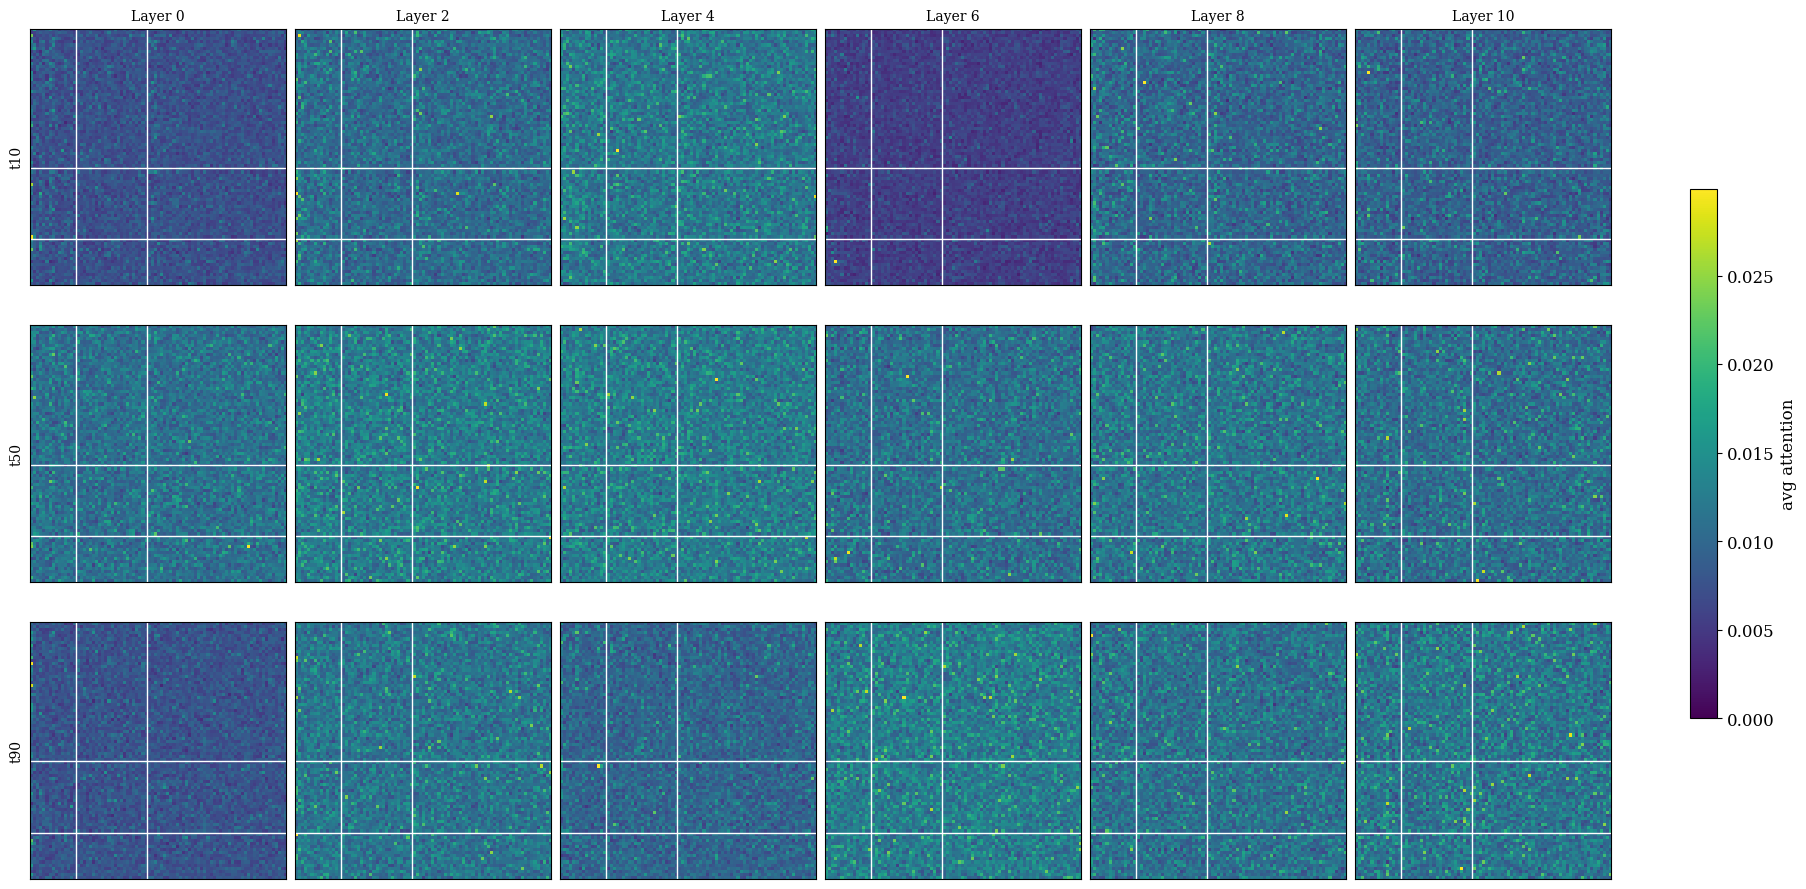

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# 1) load your snapshots
attn_snapshots = pickle.load(open(
    'configf_1200_0rots_very_big_b_eta/attn_snapshots.pkl','rb'))

snap_keys   = ['t10','t50','t90']
n_layers    = 12
layers_sel  = list(range(0, n_layers, 2))  # [0,2,4,6,8,10]
n_tokens    = 83

# token boundaries for drawing
b1, b2 = 15, 15+23  # 15 radial tokens, 23 FG tokens

fig, axes = plt.subplots(
    nrows=len(snap_keys),
    ncols=len(layers_sel),
    figsize=(3*len(layers_sel), 3*len(snap_keys)),
    constrained_layout=True)

for i, key in enumerate(snap_keys):
    layer_dict = attn_snapshots[key]
    for j, layer in enumerate(layers_sel):
        # use the 'block_x' key
        W = np.array(layer_dict[f'block_{layer}'])  # (heads, tokens, tokens)
        Wavg = W.mean(axis=0)                      # average over heads
        print(Wavg.shape)
        ax = axes[i, j]
        im = ax.imshow(
            Wavg,
            vmin=0, vmax=Wavg.max(),
            cmap='viridis',
            origin='lower',
            aspect='equal')
        # draw the radial/fg/bg boundaries
        ax.axhline(b1-.5, color='w', lw=1)
        ax.axhline(b2-.5, color='w', lw=1)
        ax.axvline(b1-.5, color='w', lw=1)
        ax.axvline(b2-.5, color='w', lw=1)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(f'Layer {layer}', fontsize=10)
        if j == 0:
            ax.set_ylabel(f'{key}', fontsize=10)

# shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.set_label('avg attention')

#plt.suptitle(
#    'Token‐vs‐Token Attention (avg over heads)\n'
#    'rows=τ‐snapshots, cols=every-2nd-layer',
#    y=1.02
#)
plt.show()


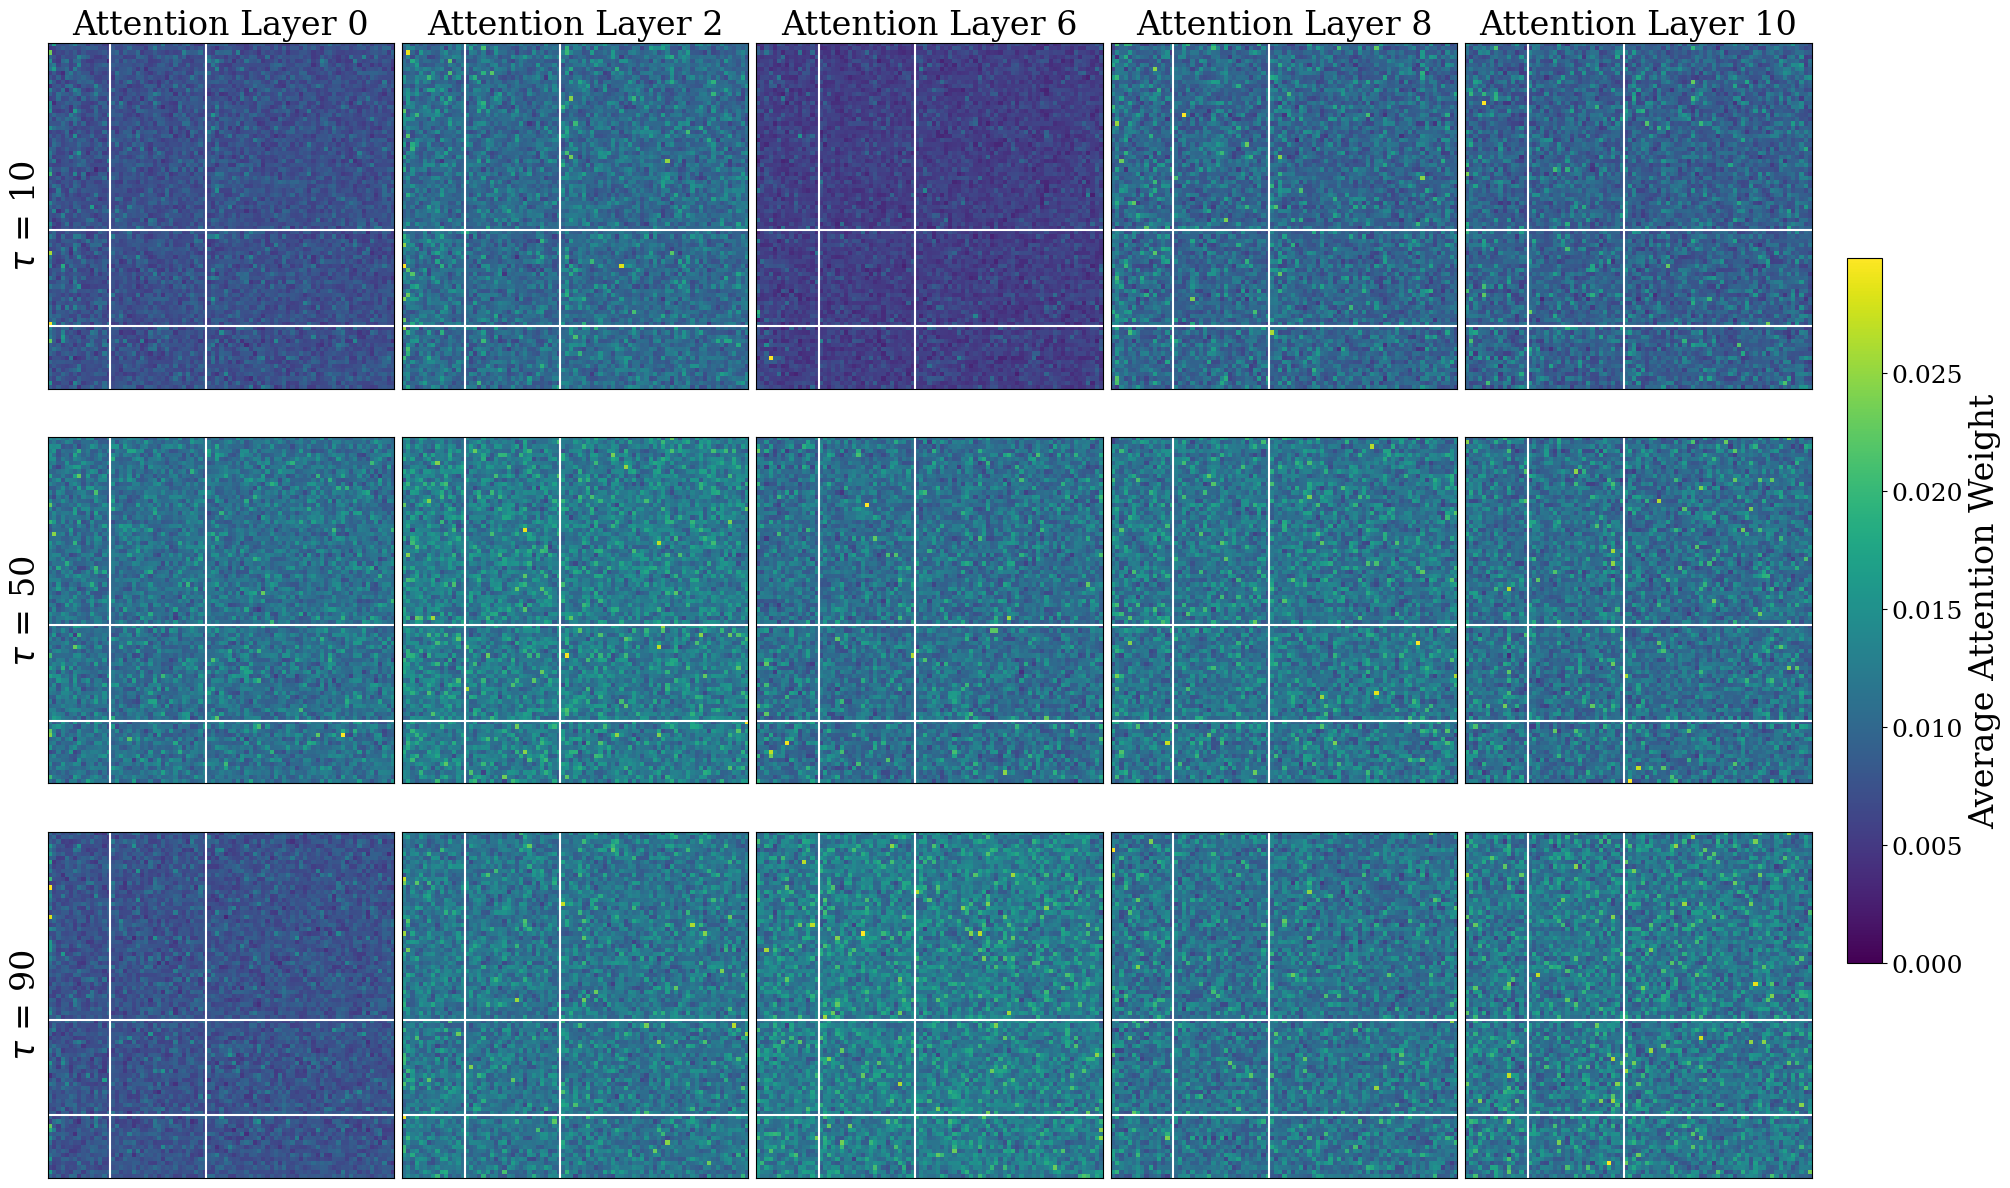

In [35]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# 1) load your snapshots
attn_snapshots = pickle.load(open(
    'configf_1200_0rots_very_big_b_eta/attn_snapshots.pkl','rb'))

snap_keys   = ['t10','t50','t90']
n_layers    = 12
# Exclude layer 4 from the selected layers
layers_sel  = [l for l in range(0, n_layers, 2) if l != 4] # [0, 2, 6, 8, 10]
n_tokens    = 83

# --- Plotting Customization ---
# Define font sizes for better readability
LABEL_FONTSIZE = 24
TITLE_FONTSIZE = 24 # For layer titles
TICK_FONTSIZE = 18 # For colorbar ticks, if applicable

# Define a dictionary for custom row labels (tau snapshots)
# You can change these display names as you wish
row_label_names = {
    't10': r'$\tau$ = 10',
    't50': r'$\tau$ = 50',
    't90': r'$\tau$ = 90',
}

# --- Token boundaries for drawing on the heatmap ---
# Based on your previous context: 15 radial tokens, 23 FG tokens
# Total tokens: Radial (15) + FG (23) + BG (83 - 15 - 23 = 45) = 83 tokens
b1, b2 = 15, 15+23

# Create the figure and subplots
# The number of columns will now dynamically adjust based on layers_sel
fig, axes = plt.subplots(
    nrows=len(snap_keys),
    ncols=len(layers_sel),
    figsize=(4 * len(layers_sel), 4 * len(snap_keys)), # Adjusted figsize for larger plots
    constrained_layout=True
)

# Ensure 'axes' is always a 2D array, even for single row/column plots
if len(snap_keys) == 1 and len(layers_sel) == 1:
    axes = np.array([[axes]])
elif len(snap_keys) == 1:
    axes = axes[np.newaxis, :]
elif len(layers_sel) == 1:
    axes = axes[:, np.newaxis]


# Loop through snapshots (rows) and layers (columns) to plot attention maps
for i, key in enumerate(snap_keys):
    layer_dict = attn_snapshots[key]
    for j, layer in enumerate(layers_sel):
        # Use the 'block_x' key for attention weights
        W = np.array(layer_dict[f'block_{layer}'])  # (heads, tokens, tokens)
        Wavg = W.mean(axis=0)                       # average over heads

        ax = axes[i, j]
        im = ax.imshow(
            Wavg,
            vmin=0, vmax=Wavg.max(), # Max value is dynamic per plot, could set a global max if desired
            cmap='viridis',
            origin='lower',
            aspect='equal'
        )

        # Draw the radial/fg/bg boundaries with white lines
        ax.axhline(b1 - 0.5, color='w', lw=1.5)
        ax.axhline(b2 - 0.5, color='w', lw=1.5)
        ax.axvline(b1 - 0.5, color='w', lw=1.5)
        ax.axvline(b2 - 0.5, color='w', lw=1.5)

        # Remove x and y ticks for cleaner appearance
        ax.set_xticks([])
        ax.set_yticks([])

        # Set column titles (Layers) only for the top row
        if i == 0:
            ax.set_title(f'Attention Layer {layer}', fontsize=TITLE_FONTSIZE)

        # Set row labels (Tau snapshots) only for the first column
        if j == 0:
            ax.set_ylabel(row_label_names.get(key, key), fontsize=LABEL_FONTSIZE) # Use dictionary for labels

# Create a single shared colorbar for all subplots
# Use 'ravel().tolist()' to get all axes in a flat list for the colorbar function
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02)
cbar.set_label('Average Attention Weight', fontsize=LABEL_FONTSIZE) # Clearer label
cbar.ax.tick_params(labelsize=TICK_FONTSIZE) # Adjust colorbar tick font size

# No overall title as requested
plt.savefig('attention.png', dpi=300)
plt.show()

/tmp/ipykernel_61151/3285050872.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


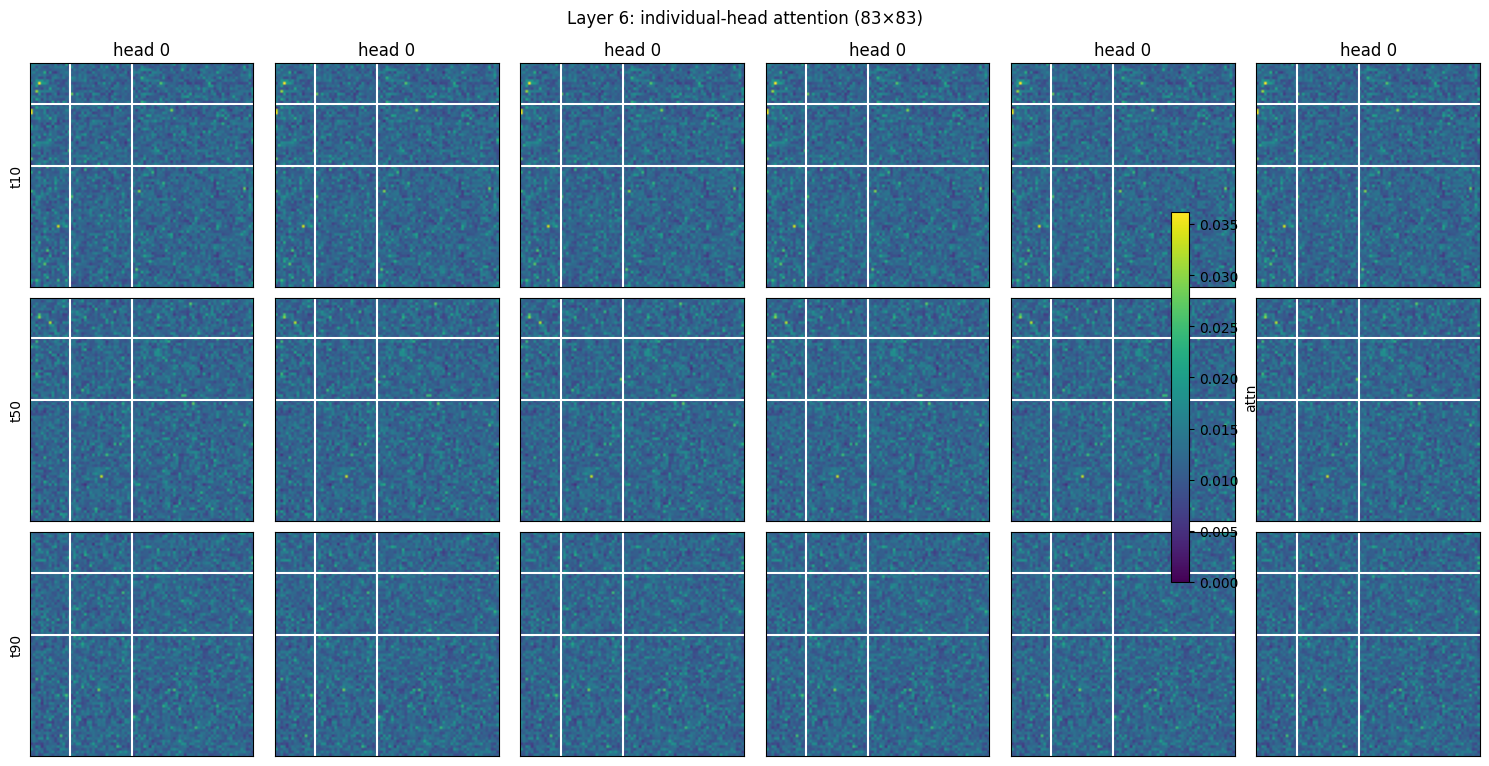

Cross-token attention (ℓ=1→ℓ=1) per τ & layer 6:
  t10:
    R1→F1 = 0.0107,  R1→G1 = 0.0099
    F1→R1 = 0.0098,  F1→G1 = 0.0155
    G1→R1 = 0.0127,  G1→F1 = 0.0121
  t50:
    R1→F1 = 0.0120,  R1→G1 = 0.0105
    F1→R1 = 0.0080,  F1→G1 = 0.0142
    G1→R1 = 0.0126,  G1→F1 = 0.0148
  t90:
    R1→F1 = 0.0100,  R1→G1 = 0.0126
    F1→R1 = 0.0082,  F1→G1 = 0.0130
    G1→R1 = 0.0108,  G1→F1 = 0.0167


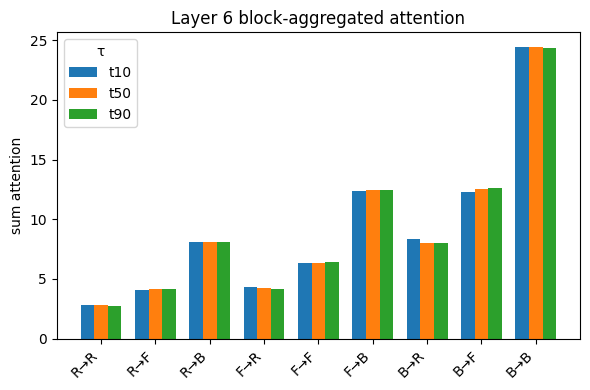

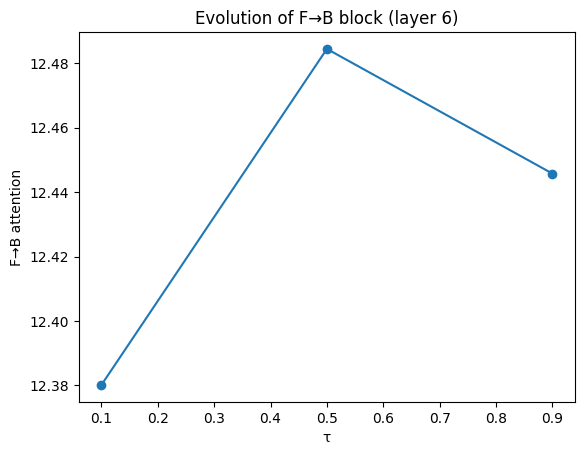

In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# load your pre-computed attention snapshots
attn = pickle.load(open('configf_1200_0rots_very_big_b_eta/attn_snapshots.pkl','rb'))
# attn is a dict: {'t10':layer_dict, 't50':…, 't90':…}
# each layer_dict is {'block_0': np.array(heads,83,83), … }

snap_keys = ['t10','t50','t90']
layers    = [6]  # you can pick others, I find block_6 showed some structure
b1 = 15      # radial tokens = ℓ=0..14  → 15 tokens
b2 = b1 + 23 # + FG ℓ=0..22 = 23 → 38
b3 = b2 + 45 # + BG ℓ=0..44 = 45 → 83

# 1) plot 3×6 mini-heatmaps of individual heads for layer6
fig, axs = plt.subplots(3, 6, figsize=(15,8),
                        subplot_kw={'xticks':[],'yticks':[]})
for i, τ in enumerate(snap_keys):
    W = attn[τ][f'block_{layers[0]}']  # shape (n_heads,83,83)
    n_heads = W.shape[0]
    # pick up to 6 heads evenly spaced
    sel_heads = np.linspace(0, n_heads-1, 6, dtype=int)
    for j,h in enumerate(sel_heads):
        ax = axs[i,j]
        im = ax.imshow(W[h], vmin=0, vmax=W.mean()*3, cmap='viridis')
        # draw group boundaries
        ax.axvline(b1-0.5, color='white'); ax.axvline(b2-0.5,color='white')
        ax.axhline(b1-0.5, color='white'); ax.axhline(b2-0.5,color='white')
        if i==0: ax.set_title(f'head {h}')
        if j==0: ax.set_ylabel(τ)
plt.suptitle('Layer 6: individual-head attention (83×83)')
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, label='attn')
plt.tight_layout()
plt.show()

# 2) cross-talk for “token 1” of each group (ℓ=1 → token idx=1 in each block)
print("Cross-token attention (ℓ=1→ℓ=1) per τ & layer 6:")
for τ in snap_keys:
    Wavg = attn[τ][f'block_6'].mean(axis=0)  # avg over heads
    # token indexes:
    r1 = 1
    f1 = b1 + 1
    g1 = b2 + 1
    print(f"  {τ}:")
    print(f"    R1→F1 = {Wavg[r1,f1]:.4f},  R1→G1 = {Wavg[r1,g1]:.4f}")
    print(f"    F1→R1 = {Wavg[f1,r1]:.4f},  F1→G1 = {Wavg[f1,g1]:.4f}")
    print(f"    G1→R1 = {Wavg[g1,r1]:.4f},  G1→F1 = {Wavg[g1,f1]:.4f}")

# 3) block-level aggregation for each τ & layer6
blocks = ['R→R','R→F','R→B','F→R','F→F','F→B','B→R','B→F','B→B']
agg = {τ: {} for τ in snap_keys}
for τ in snap_keys:
    Wavg = attn[τ][f'block_6'].mean(axis=0)
    agg[τ]['R→R'] = Wavg[:b1, :b1].sum()
    agg[τ]['R→F'] = Wavg[:b1, b1:b2].sum()
    agg[τ]['R→B'] = Wavg[:b1, b2:].sum()
    agg[τ]['F→R'] = Wavg[b1:b2, :b1].sum()
    agg[τ]['F→F'] = Wavg[b1:b2, b1:b2].sum()
    agg[τ]['F→B'] = Wavg[b1:b2, b2:].sum()
    agg[τ]['B→R'] = Wavg[b2:, :b1].sum()
    agg[τ]['B→F'] = Wavg[b2:, b1:b2].sum()
    agg[τ]['B→B'] = Wavg[b2:, b2:].sum()

# bar-plot of the 9 blocks
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(blocks))
width = 0.25
for i, τ in enumerate(snap_keys):
    ax.bar(x + (i-1)*width, [agg[τ][b] for b in blocks], width, label=τ)
ax.set_xticks(x); ax.set_xticklabels(blocks, rotation=45, ha='right')
ax.set_ylabel('sum attention'); ax.legend(title='τ')
plt.title('Layer 6 block-aggregated attention')
plt.tight_layout()
plt.show()

# 4) plot evolution of one block (e.g. F→B) over τ
fig, ax = plt.subplots()
vals = [agg[τ]['F→B'] for τ in snap_keys]
ax.plot([0.1,0.5,0.9], vals, marker='o')
ax.set_xlabel('τ'); ax.set_ylabel('F→B attention')
ax.set_title('Evolution of F→B block (layer 6)')
plt.show()

# 5) yes, every Wavg is 83×83 — 1 token per ℓ from 0…44 split into R(0–14),F(0–22),B(0–44)



/tmp/ipykernel_61151/3556477958.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


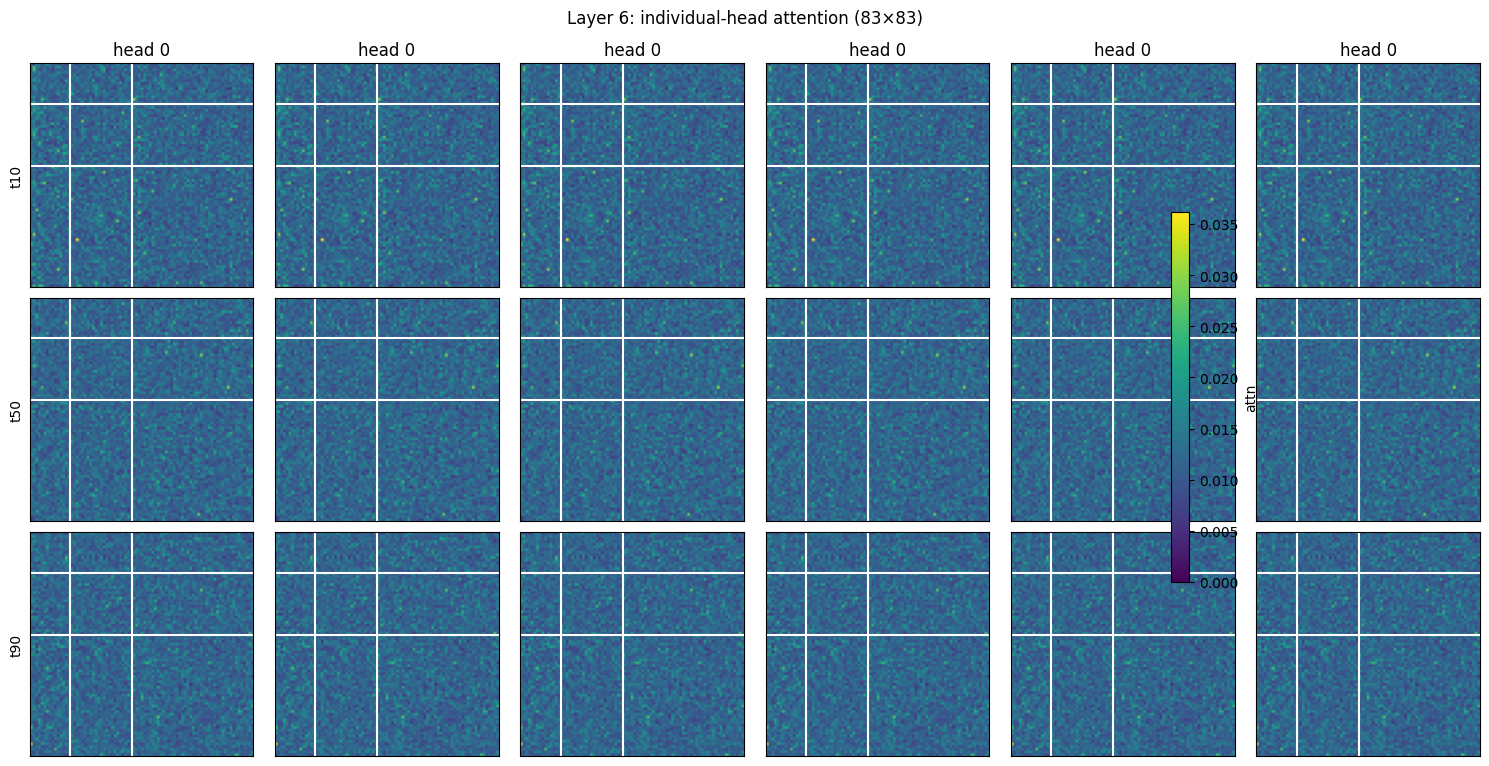

Cross-token attention (ℓ=1→ℓ=1) per τ & layer 6:
  t10:
    R1→F1 = 0.0107,  R1→G1 = 0.0099
    F1→R1 = 0.0098,  F1→G1 = 0.0155
    G1→R1 = 0.0127,  G1→F1 = 0.0121
  t50:
    R1→F1 = 0.0120,  R1→G1 = 0.0105
    F1→R1 = 0.0080,  F1→G1 = 0.0142
    G1→R1 = 0.0126,  G1→F1 = 0.0148
  t90:
    R1→F1 = 0.0100,  R1→G1 = 0.0126
    F1→R1 = 0.0082,  F1→G1 = 0.0130
    G1→R1 = 0.0108,  G1→F1 = 0.0167


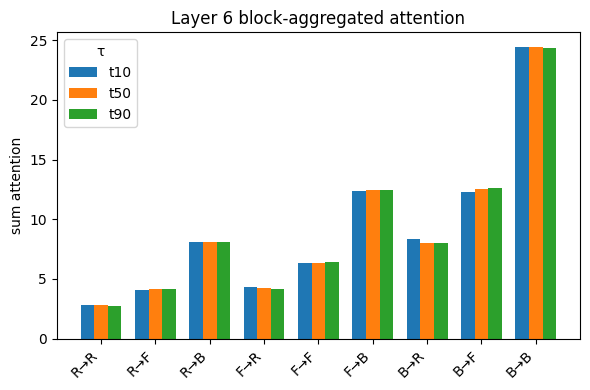

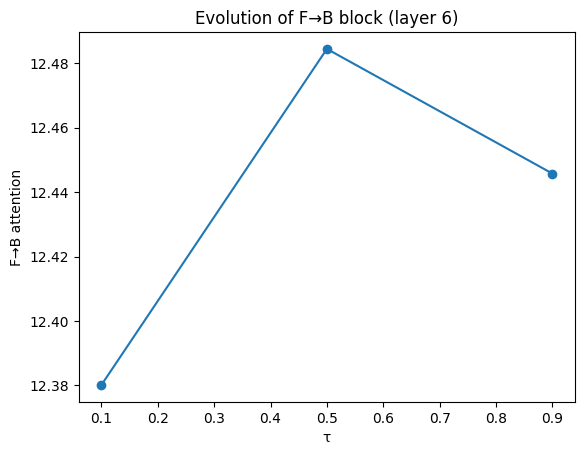

In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# load your pre-computed attention snapshots
attn = pickle.load(open('configf_1200_0rots_very_big_b_eta/attn_snapshots.pkl','rb'))
# attn is a dict: {'t10':layer_dict, 't50':…, 't90':…}
# each layer_dict is {'block_0': np.array(heads,83,83), … }

snap_keys = ['t10','t50','t90']
layers    = [8]  # you can pick others, I find block_6 showed some structure
b1 = 15      # radial tokens = ℓ=0..14  → 15 tokens
b2 = b1 + 23 # + FG ℓ=0..22 = 23 → 38
b3 = b2 + 45 # + BG ℓ=0..44 = 45 → 83

# 1) plot 3×6 mini-heatmaps of individual heads for layer6
fig, axs = plt.subplots(3, 6, figsize=(15,8),
                        subplot_kw={'xticks':[],'yticks':[]})
for i, τ in enumerate(snap_keys):
    W = attn[τ][f'block_{layers[0]}']  # shape (n_heads,83,83)
    n_heads = W.shape[0]
    # pick up to 6 heads evenly spaced
    sel_heads = np.linspace(0, n_heads-1, 6, dtype=int)
    for j,h in enumerate(sel_heads):
        ax = axs[i,j]
        im = ax.imshow(W[h], vmin=0, vmax=W.mean()*3, cmap='viridis')
        # draw group boundaries
        ax.axvline(b1-0.5, color='white'); ax.axvline(b2-0.5,color='white')
        ax.axhline(b1-0.5, color='white'); ax.axhline(b2-0.5,color='white')
        if i==0: ax.set_title(f'head {h}')
        if j==0: ax.set_ylabel(τ)
plt.suptitle('Layer 6: individual-head attention (83×83)')
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, label='attn')
plt.tight_layout()
plt.show()

# 2) cross-talk for “token 1” of each group (ℓ=1 → token idx=1 in each block)
print("Cross-token attention (ℓ=1→ℓ=1) per τ & layer 6:")
for τ in snap_keys:
    Wavg = attn[τ][f'block_6'].mean(axis=0)  # avg over heads
    # token indexes:
    r1 = 1
    f1 = b1 + 1
    g1 = b2 + 1
    print(f"  {τ}:")
    print(f"    R1→F1 = {Wavg[r1,f1]:.4f},  R1→G1 = {Wavg[r1,g1]:.4f}")
    print(f"    F1→R1 = {Wavg[f1,r1]:.4f},  F1→G1 = {Wavg[f1,g1]:.4f}")
    print(f"    G1→R1 = {Wavg[g1,r1]:.4f},  G1→F1 = {Wavg[g1,f1]:.4f}")

# 3) block-level aggregation for each τ & layer6
blocks = ['R→R','R→F','R→B','F→R','F→F','F→B','B→R','B→F','B→B']
agg = {τ: {} for τ in snap_keys}
for τ in snap_keys:
    Wavg = attn[τ][f'block_6'].mean(axis=0)
    agg[τ]['R→R'] = Wavg[:b1, :b1].sum()
    agg[τ]['R→F'] = Wavg[:b1, b1:b2].sum()
    agg[τ]['R→B'] = Wavg[:b1, b2:].sum()
    agg[τ]['F→R'] = Wavg[b1:b2, :b1].sum()
    agg[τ]['F→F'] = Wavg[b1:b2, b1:b2].sum()
    agg[τ]['F→B'] = Wavg[b1:b2, b2:].sum()
    agg[τ]['B→R'] = Wavg[b2:, :b1].sum()
    agg[τ]['B→F'] = Wavg[b2:, b1:b2].sum()
    agg[τ]['B→B'] = Wavg[b2:, b2:].sum()

# bar-plot of the 9 blocks
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(blocks))
width = 0.25
for i, τ in enumerate(snap_keys):
    ax.bar(x + (i-1)*width, [agg[τ][b] for b in blocks], width, label=τ)
ax.set_xticks(x); ax.set_xticklabels(blocks, rotation=45, ha='right')
ax.set_ylabel('sum attention'); ax.legend(title='τ')
plt.title('Layer 6 block-aggregated attention')
plt.tight_layout()
plt.show()

# 4) plot evolution of one block (e.g. F→B) over τ
fig, ax = plt.subplots()
vals = [agg[τ]['F→B'] for τ in snap_keys]
ax.plot([0.1,0.5,0.9], vals, marker='o')
ax.set_xlabel('τ'); ax.set_ylabel('F→B attention')
ax.set_title('Evolution of F→B block (layer 6)')
plt.show()

# 5) yes, every Wavg is 83×83 — 1 token per ℓ from 0…44 split into R(0–14),F(0–22),B(0–44)

